<br>

# Analysis of Forest Cover Growth in India

**Exploratory Data Analysis, management of missing data, regionalised clustering and regression models to explain the complexities of forest cover growth in India.**

<br>

There are studies and articles available that expands on the topic of India’s loss of forests, which is among the highest in the world. This issue is commonly attributed to the work of agriculture throughout the country, where forests could be cleared for their by-products or to make fertile pastures on cleared land. Urban expansion is also another issue typically raised in such a context as a reason for deforestation. Although there is truth to such a correlation, the loss of forests is a multi-faceted issue that may not be linearly correlated across the whole country.

This assignment will explore the common existing hypothesis about India’s loss of forests. It is typically understood that the higher the agricultural activities in certain districts, the higher rate of deforestation or rate of forest growth follow. These exact variables are not available on the SHRUG database, hence other variables will be used as a proxy to indicate a similar relationship.

The previous hypothesis also included an exploration into manufacturing industries to account for low forest growth due to pollution from such activities. However, after some revision, the agriculture industry will be the focus of this hypothesis as manufacturing industries tend to be clustered in urban areas where forests are already lacking. Furthermore, deforestation activity can be observed when there is a lack of cultivable land with a high proportion of agricultural labour. Hence these new variables will be examined instead. Furthermore, greater use of forests for agriculture could also happen to areas where the initial amount of forests is higher.

The analysis measures the proportion of agricultural labour, proportion of rural farmers and the initial Vegetation Continuous Fields (VCF) values of each district in 2011 to compare with the average subsequent growth of VCF from 2011 to 2020 (the most recent year in the dataset).

<br>

***

<br>

**Independent variables:**
-	**Initial VCF in 2011:** shortened to VCF in 2011 in the dataframes. This will also be the starting point of the average VCF growth calculations. Taken from the VCF dataset
-	**Total cultivable area (hac):** taken from the Mission Antyodaya dataset, estimating the amount of cultivable land. Low availability of cultivable land could lead farmers to clear more forest for arable land.
-	**District land size (area sqmm):** was initially taken into account but it does not account for the fact that some land may be unusable for agriculture and hence was dropped despite higher correlation with Average VCF increase.
-	**Proportion of agricultural labour (%):** this is calculated by dividing the total number of agricultural workers by the total number of workers in each district.
-	**Proportion of rural farmers (%):** this is calculated by dividing the total number of rural farmers by the total population of the rural communities in each district.


**Agricultural workers in this dataset refers to organised commercial businesses conducting work relevant to the agricultural industry in each district of India while rural farmers refer to smaller-scale farmers engaged in agricultural work.**
<br>

<br/>

**Dependent variable(s):**
-	**Average VCF increase (%):** the average rate of forest growth from 2011 to 2020. Taken from the VCF dataset.
-	**Relationship between independent variables and Average VCF increase:** this is the variable that will be measured to prove or disprove the hypothesis.

<br/>

<br/>

Comparing with the previous assignment, there is a lot more missing data presented in this dataset than the Den Haag cijfers. The kind of data available is also limited and hence a lot more other variables are used as proxies and many assumptions had to be made as a result.


Unfortunately, districts were drawn differently or missing from the 1991 and 2001 population census data and the most recent dataset would be the 2011 version of the population census, hence this would be preferably used in the analysis. Another variable that could have been more helpful and accurate to use is any direct measurement of agricultural activities, such as economic gain of agricultural sectors in each district. However, the economic census does not include agricultural firms and hence it will be assumed that proportion of agricultural labour and rural farmers are aptly proportional to the amount of agricultural activity. It is also assumed that all agricultural activity involves minimising forests, which is not necessarily true as different communities practice different techniques for different crops.


There is also the presumption of accuracy of the VCF method. As it depends on the resolution of satellite imagery, the level of accuracy of the VCF 10 to 20 years ago may not be as much as that of recent years.

<br/>

**Possible reasons for rejection:**  Due to the kind of assumptions made, there may be a strong correlation between the variables chosen but other factors not present in the available datasets could prove that this may be only a surface-level observation. There are also other aspects that contribute to the forest loss or low growth rates in India that were not accounted for as this is actually a highly complex and multifaceted issue.

<br/>

**Possible reasons for false acceptance:** The relationship between the industry and agricultural growth and forest cover loss has been studied before and there are lots of documentations and research out there that have explored this. And if similar conclusions are drawn here, it would not be difficult to accept these trends despite the aforementioned flaws.

<br/>

# 3.0: Connecting to Google Drive, package installation and imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

!pip install osmnx
!pip install pysal
!pip install cartopy
!pip install contextily
!pip install xyzservices
!pip install esda
!pip install pygam


In [ ]:
%matplotlib inline
import seaborn as sns
import pandas as pd
from pysal.lib import weights
import libpysal
import geopandas as gpd
import numpy as np
import matplotlib as mpl

import osmnx as ox
from esda.moran import Moran_Local
from libpysal.io import open as psopen
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

import cartopy.crs as ccrs
from cartopy.io import shapereader
import contextily as cx
import xyzservices.providers as xyz

from pysal.explore import esda
from esda import Moran
from splot.esda import moran_scatterplot
from splot.esda import lisa_cluster
from sklearn import cluster

from pygam import LogisticGAM

/usr/local/lib/python3.10/dist-packages/spaghetti/network.py:42: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(dep_msg, FutureWarning, stacklevel=1)


<br/>

# 3.1 Cleaning data and calculations

</br>

###3.1.1 Reading file paths

In [ ]:
#file paths
pca_2011_dist = '/content/drive/MyDrive/Colab Notebooks/assignment-03/data/pc11_pca_clean_pc11dist.csv'
vcf = '/content/drive/MyDrive/Colab Notebooks/assignment-03/data/vcf_pc11dist.csv'
rural = '/content/drive/MyDrive/Colab Notebooks/assignment-03/data/antyodaya_pc11dist.csv'
dist_shp = '/content/drive/MyDrive/Colab Notebooks/assignment-03/data/district/district.shp'

#read files
pca_2011_original = pd.read_csv(pca_2011_dist)
vcf_original = pd.read_csv(vcf)
rural_original = pd.read_csv(rural)
dist = gpd.read_file(dist_shp)

</br>

###3.1.2 Cleaning data: creating dataframes


1.   df2011: dataframe containing total population size and agricultural labour size per district
2.   vcf_new: dataframe containing mean vcf values from 2011 to 2020 per district
3.   rural_data: dataframe containing rural populations, farmers and cultivable land area
4.   dist: geodataframe containing district shape files


In [ ]:
#population data
df2011 = pd.DataFrame()

col_2011 = ['pc11_district_id', 'pc11_pca_tot_work_p', 'pc11_pca_main_al_p', 'pc11_pca_marg_al_p']
df2011[col_2011] = pca_2011_original[col_2011].copy()

#renaming columns for better clarity and combining all agricultural workers and all manufacturing workers
new_cols = ['District ID', 'Total workers (#)', 'Total main agricultural workers (#)', 'Total marginal agricultural workers (#)']
now_cols = list(df2011.columns.values)


for now in now_cols:
    new = new_cols[now_cols.index(now)]
    df2011 = df2011.rename(columns={now:new}, errors="raise")

df2011.head()

,District ID,Total workers (#),Total main agricultural workers (#),Total marginal agricultural workers (#)
0,1,229064,9834,46925
1,2,214866,11560,25070
2,3,75079,593,1052
3,4,51873,524,3239
4,5,161393,5917,25666


Creating the dataframe for average VCF calculation:

Because the VCF of years 2001 to 2010 will not be part of the calculation, these rows were removed.

In [ ]:
#VCF data
vcf_new = vcf_original.drop(vcf_original[vcf_original['year'] < 2011].index)

cols_delete = ['vcf_min', 'vcf_max', 'vcf_num_cells', 'pc11_state_id']
vcf_new = vcf_new.drop(cols_delete, axis=1)

vcf_new = vcf_new.rename(columns={'pc11_district_id':'District ID'}, errors="raise")
vcf_new = vcf_new.rename(columns={'vcf_mean':'VCF mean'}, errors="raise")

vcf_new.reset_index(drop=True, inplace=True)

vcf_new.head()

,District ID,VCF mean,year
0,1,28.426696,2011
1,1,31.468217,2012
2,1,32.104691,2013
3,1,31.468806,2014
4,1,35.961908,2015


Creating the dataframe initial VCF in 2011

In [ ]:
#initial mean VCF value in 2011
vcf_2011_init = vcf_original.drop(vcf_original[vcf_original['year'] != 2011].index)
vcf_2011_init = vcf_2011_init.drop(cols_delete, axis=1)
vcf_2011_init = vcf_2011_init.drop('year', axis=1)

now_cols_2 = ['pc11_district_id', 'vcf_mean']
new_cols_2 = ['District ID', 'VCF in 2011']

for now in now_cols_2:
    new = new_cols_2[now_cols_2.index(now)]
    vcf_2011_init = vcf_2011_init.rename(columns={now:new}, errors="raise")

vcf_2011_init.reset_index(drop=True, inplace=True)
vcf_2011_init.head()

,District ID,VCF in 2011
0,1,28.426696
1,2,12.234603
2,3,1.098495
3,4,1.695090
4,5,23.615615


Creating the geodataframe with district shape files to be used for choropleths

In [ ]:
#geodataframe
dist = dist.rename(columns={'pc11_d_id':'District ID'}, errors="raise")
dist = dist.sort_values('District ID', ascending=True)
dist.drop(dist[dist['District ID'] == '000'].index, inplace=True)
dist.reset_index(drop=True, inplace=True)
dist.head()

,pc11_s_id,District ID,d_name,geometry
0,01,001,Kupwara,"POLYGON ((74.46243 34.48548, 74.46090 34.48509..."
1,01,002,Badgam,"POLYGON ((74.70078 34.11242, 74.70130 34.11225..."
2,01,003,Leh(Ladakh),"POLYGON ((77.87244 35.43315, 77.88284 35.43070..."
3,01,004,Kargil,"POLYGON ((76.25634 34.68381, 76.25740 34.68065..."
4,01,005,Punch,"POLYGON ((74.30487 33.99313, 74.30529 33.99253..."


Creating the dataframe for calculating proportion of rural farmers and total cultivable land:

There are some districts missing, thus this dataframe has less rows than the more complete dataframes from the population census and VCF. The rural data would need more work to impute missing data and to keep track of the missing districts in the dataset. This could be due to the fact that information and surveying is difficult in rural areas as literacy rates and accessibility vary depending on resources and infrastructure.

In [ ]:
#rural data
rural_data = pd.DataFrame()

rural_var_now = ['pc11_district_id', 'total_no_of_farmers', 'total_population', 'total_cultivable_area_in_hac']
rural_var_new = ['District ID', 'Total farmers (#)', 'Total rural population (#)', 'Total cultivable area (hac)']

rural_data[rural_var_new] = rural_original[rural_var_now]

#range of district numbers
all_district_numbers = range(1, max(rural_data['District ID']) + 1)

#missing district
missing_districts = set(all_district_numbers) - set(rural_data['District ID'])

#add empty rows for missing districts
mis_dist_df = pd.DataFrame()
mis_dist_ls = []

for d in missing_districts:
    rural_data = pd.concat([rural_data, pd.DataFrame([[d] + [None] * (len(rural_var_new)-1)], columns=rural_var_new)])
    mis_dist_df = pd.concat([mis_dist_df, pd.DataFrame([[d]], columns=['District ID'])])
    mis_dist_ls.append(d)


rural_data = rural_data.sort_values('District ID', ascending=True)
rural_data.reset_index(drop=True, inplace=True)
rural_data['District name'] = dist['d_name'].copy()

rural_data.tail()

,District ID,Total farmers (#),Total rural population (#),Total cultivable area (hac),District name
635,636,NaN,NaN,NaN,Mahe
636,637,NaN,NaN,NaN,Karaikal
637,638,2117.589041,28029.945205,NaN,Nicobars
638,639,16343.759506,111289.857972,50735.469903,North & Middle Andaman
639,640,5462.576097,113068.528297,21677.030340,South Andaman


</br>

##### *Keeping track of districts that were completely missing from the Mission Antyodaya dataset*#####


In [ ]:
#reset the index of mis_dist_df and rural_data
mis_dist_df.reset_index(drop=True, inplace=True)
rural_data.reset_index(drop=True, inplace=True)

#filter rural_data for the missing districts in mis_dist_df
rural_data_missing = rural_data[rural_data['District ID'].isin(mis_dist_df['District ID'])]
rural_data_missing.reset_index(drop=True, inplace=True)
mis_dist_df['District name'] = rural_data_missing['District name'].copy()
mis_dist_df.reset_index(drop=True, inplace=True)

mis_dist_df.head()

,District ID,District name
0,1,Kupwara
1,518,Bandipore
2,519,Srinagar
3,9,Reasi
4,10,Chandigarh


</br>

### ``3.1.3 Calculating agriculture labour size proportion``###

Total agriculutral workers (main + marginal) divided by the the total workers to be converted to a percentage to be used in the next section for analysis.

In [ ]:
#number of rows in original dataframe
numrows = df2011.shape[0]
print(numrows)

640


In [ ]:
df2011['Total agricultural workers (#)'] = df2011['Total marginal agricultural workers (#)'] + df2011['Total main agricultural workers (#)']

cols_delete1 = ['Total main agricultural workers (#)', 'Total marginal agricultural workers (#)']
df2011_2 = df2011.drop(cols_delete1, axis=1)

df2011_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 3 columns):
 #   Column                          Non-Null Count  Dtype
---  ------                          --------------  -----
 0   District ID                     640 non-null    int64
 1   Total workers (#)               640 non-null    int64
 2   Total agricultural workers (#)  640 non-null    int64
dtypes: int64(3)
memory usage: 15.1 KB


In [ ]:
#total agricultural workers as a proportion to the district population

df2011_2['Proportion of agricultural labour (%)'] = df2011_2['Total agricultural workers (#)']/df2011_2['Total workers (#)']*100
cols_delete2 = ['Total workers (#)', 'Total agricultural workers (#)']
df2011_3 = df2011_2.drop(cols_delete2, axis=1)
df2011_3 = df2011_3.sort_values('District ID', ascending=True)
df2011_3.reset_index(drop=True, inplace=True)
df2011_3.head(numrows)

,District ID,Proportion of agricultural labour (%)
0,1,24.778664
1,2,17.047834
2,3,2.191025
3,4,7.254256
4,5,19.569002
...,...,...
635,636,0.694797
636,637,19.146133
637,638,1.413139
638,639,4.963840


</br>

### ``3.1.4 Calculating average VCF increase``###

The average percentage increase in VCF values from the starting point of 2011 to 2020.

In [ ]:
#calculating VCF percentage increase

grouped_df = vcf_new.groupby('District ID')['VCF mean'].pct_change() * 100

#group by district and calculate the mean percentage increase
vcf_increases = grouped_df.groupby(level=0).mean().reset_index(name='vcf_mean')

del vcf_increases['index']
vcf_increases.reset_index()

vcf_new2 = pd.DataFrame()
vcf_new2['District ID'] = vcf_new['District ID'].copy()
vcf_new2['VCF percentage increase (%)'] = vcf_increases['vcf_mean']

vcf_new2.head(-1)


,District ID,VCF percentage increase (%)
0,1,NaN
1,1,10.699523
2,1,2.022592
3,1,-1.980661
4,1,14.277957
...,...,...
6394,640,NaN
6395,640,NaN
6396,640,NaN
6397,640,NaN


In [ ]:
#calculating average VCF percentage increase
average_perc_inc_vcf = vcf_new2.groupby('District ID')['VCF percentage increase (%)'].mean().reset_index()
average_perc_inc_vcf_2 = average_perc_inc_vcf.sort_values('District ID', ascending=True)
average_perc_inc_vcf_2.head(numrows)

,District ID,VCF percentage increase (%)
0,1,2.016496
1,2,3.331161
2,3,8.164468
3,4,12.182668
4,5,2.122981
...,...,...
635,636,9.268224
636,637,11.417878
637,638,NaN
638,639,NaN


In [ ]:
average_perc_inc_vcf_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 640 entries, 0 to 639
Data columns (total 2 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   District ID                  640 non-null    int64  
 1   VCF percentage increase (%)  637 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 15.0 KB


</br>

### ``3.1.5 Cleaning data: rural farming dataset``###

In [ ]:
#calculating proportion of rural farmers
rural_data_2 = pd.DataFrame()

rural_data['Proportion of rural farmers (%)'] = rural_data['Total farmers (#)'] / rural_data['Total rural population (#)'] * 100

new_cols_3 = ['District ID', 'District name', 'Proportion of rural farmers (%)', 'Total cultivable area (hac)']

rural_data_2[new_cols_3] = rural_data[new_cols_3].copy()

rural_data_2.head()

,District ID,District name,Proportion of rural farmers (%),Total cultivable area (hac)
0,1,Kupwara,NaN,NaN
1,2,Badgam,14.503717,57948.175070
2,3,Leh(Ladakh),20.572685,15956.018711
3,4,Kargil,14.530522,43435.821971
4,5,Punch,13.187678,156668.078084


</br>

### ``3.1.6 Combining datasets``###

The average VCF percentage increase variable will be appended into the dataframe containing the labour size data to be efficiently compared together. Data for each variable will match their corresponding districts. This dataframe gives a rough trend of high labour size in agriculture leading to low average VCF percentage increase. For many districts, these are negative values, meaning forest cover is actively lost over the years on average since 2011.

In [ ]:
df_al_vcf_land = pd.DataFrame()

In [ ]:
#combining datasets
df_al_vcf_land['District ID'] = df2011_3['District ID'].copy()
df_al_vcf_land['District name'] = rural_data_2['District name'].copy()
df_al_vcf_land['Proportion of agricultural labour (%)'] = df2011_3['Proportion of agricultural labour (%)'].copy()
df_al_vcf_land['Average VCF increase (%)'] = average_perc_inc_vcf['VCF percentage increase (%)'].copy()
df_al_vcf_land['VCF in 2011'] = vcf_2011_init['VCF in 2011'].copy()
df_al_vcf_land['Proportion of rural farmers (%)'] = rural_data_2['Proportion of rural farmers (%)'].copy()
df_al_vcf_land['Total cultivable area (hac)'] = rural_data_2['Total cultivable area (hac)'].copy()
df_al_vcf_land = df_al_vcf_land.sort_values('District ID', ascending=True)
df_al_vcf_land.head(numrows)

,District ID,District name,Proportion of agricultural labour (%),Average VCF increase (%),VCF in 2011,Proportion of rural farmers (%),Total cultivable area (hac)
0,1,Kupwara,24.778664,2.016496,28.426696,NaN,NaN
1,2,Badgam,17.047834,3.331161,12.234603,14.503717,57948.175070
2,3,Leh(Ladakh),2.191025,8.164468,1.098495,20.572685,15956.018711
3,4,Kargil,7.254256,12.182668,1.695090,14.530522,43435.821971
4,5,Punch,19.569002,2.122981,23.615615,13.187678,156668.078084
...,...,...,...,...,...,...,...
635,636,Mahe,0.694797,9.268224,22.476636,NaN,NaN
636,637,Karaikal,19.146133,11.417878,10.124498,NaN,NaN
637,638,Nicobars,1.413139,NaN,0.000000,7.554738,NaN
638,639,North & Middle Andaman,4.963840,NaN,0.000000,14.685758,50735.469903


In [ ]:
#combine with geodataframe
dist.to_crs(epsg=4326, inplace=True)
df_al_vcf_land['District land size (area sqmm)'] = dist.area * 1000000
df_al_vcf_land.tail()

<ipython-input-22-29310cbbd6cf>:3: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df_al_vcf_land['District land size (area sqmm)'] = dist.area * 1000000


,District ID,District name,Proportion of agricultural labour (%),Average VCF increase (%),VCF in 2011,Proportion of rural farmers (%),Total cultivable area (hac),District land size (area sqmm)
635,636,Mahe,0.694797,9.268224,22.476636,NaN,NaN,691.338255
636,637,Karaikal,19.146133,11.417878,10.124498,NaN,NaN,13369.656182
637,638,Nicobars,1.413139,NaN,0.000000,7.554738,NaN,140641.255553
638,639,North & Middle Andaman,4.963840,NaN,0.000000,14.685758,50735.469903,238248.914852
639,640,South Andaman,2.709876,NaN,0.000000,4.831208,21677.030340,186534.912458


Data from districts 638, 639 and 640 will be dropped as they are island districts. The island economies don't function the same way as the mainland districts. Furthermore, VCF data for these areas are unavailable. Hence, the island districts will be dropped.

**df_al_vcf_land_2 will be used temporarily to make the preliminary analysis of the correlations between variables to observe patterns in existing values. Missing values will be imputed for the rest of the spatial analysis to provide a more complete overview of the relationships.**

In [ ]:
#drop island districts
df_al_vcf_land_1 = df_al_vcf_land.dropna(subset=['Average VCF increase (%)'])
df_al_vcf_land_2 = df_al_vcf_land_1.dropna(subset=['Proportion of rural farmers (%)'])
df_al_vcf_land_2 = df_al_vcf_land_2.dropna(subset=['Total cultivable area (hac)'])
df_al_vcf_land_2.head(numrows)

,District ID,District name,Proportion of agricultural labour (%),Average VCF increase (%),VCF in 2011,Proportion of rural farmers (%),Total cultivable area (hac),District land size (area sqmm)
1,2,Badgam,17.047834,3.331161,12.234603,14.503717,57948.175070,1.218271e+05
2,3,Leh(Ladakh),2.191025,8.164468,1.098495,20.572685,15956.018711,4.884437e+06
3,4,Kargil,7.254256,12.182668,1.695090,14.530522,43435.821971,1.354654e+06
4,5,Punch,19.569002,2.122981,23.615615,13.187678,156668.078084,1.746596e+05
5,6,Rajouri,8.255417,2.819744,20.768336,23.011949,75651.774652,2.693616e+05
...,...,...,...,...,...,...,...,...
628,629,Kanniyakumari,10.721727,3.109558,30.186579,13.843809,38721.341022,1.352848e+05
629,630,Dharmapuri,35.590479,8.593030,13.400068,9.607276,208877.124635,3.737068e+05
630,631,Krishnagiri,29.999351,13.403574,8.045369,10.454860,332889.502303,4.215408e+05
631,632,Coimbatore,14.670493,5.614665,16.369267,9.877604,173018.971922,3.915413e+05


</br>

#3.2 Analysing correlations



In [ ]:
columns = ['Average VCF increase (%)', 'VCF in 2011', 'Proportion of rural farmers (%)',
           'Total cultivable area (hac)', 'Proportion of agricultural labour (%)']

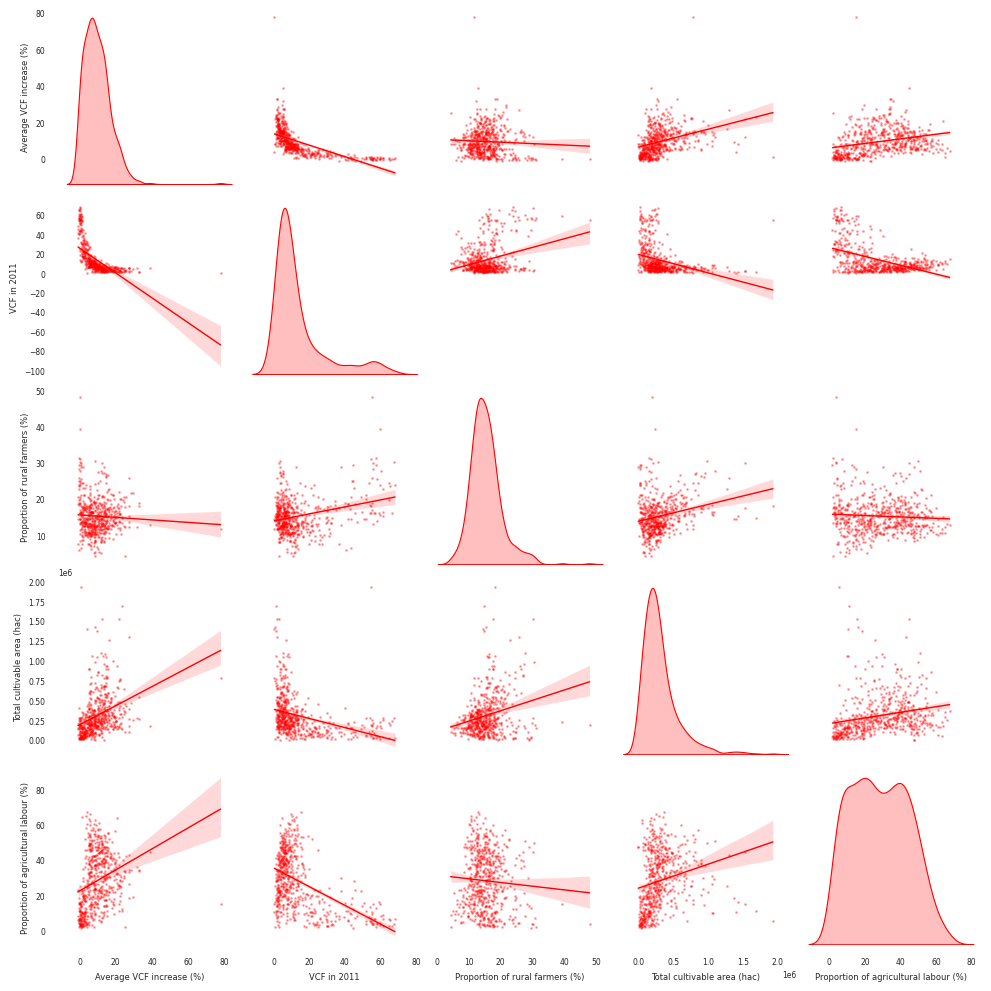

In [ ]:
sns.set_theme()
sns.set_style(style='whitegrid', rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'}, font_scale=0.5)

_ = sns.pairplot(df_al_vcf_land_2[columns], kind='reg', diag_kind='kde',
                 plot_kws={'scatter_kws': {'s': 1, 'alpha': 0.3, 'color': 'red'},
                           'line_kws': {'color': 'red', 'linewidth': 1}},
                 diag_kws={'color': 'red', 'linewidth': 0.8}, height=2, aspect=1)

The correlation of between the different variables will be tested to briefly to analyse if there are definitive global trends. First a two-variable correlation test between various independent variables with the calculated average VCF increase will be measured to observe if these values have any sort of proportion. Then a three-variable correlation analysis is conducted to observe if the average VCF increase can be affected by more factors that is globally observed.

</br>

### ``3.2.1.1 testing two-variable correlations with Average VCF increase``###


1.   Proportion of agricultural labour (%): from population census
2.   District size (area sqmm): from geodataframe
3.   VCF in 2011 (inital vcf values): from vcf dataset
4.   Average VCF Increase (%): from vcf dataset






Correlation coefficient for agricultural labour size: 0.27 

Correlation coefficient for district land size: 0.27 

Correlation coefficient for Initial VCF value in 2011: -0.64 



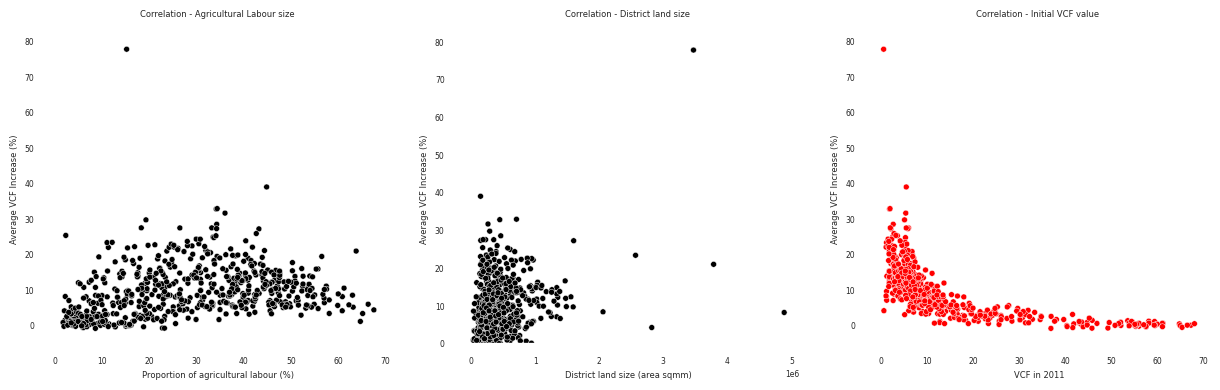

In [ ]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

####################

#plot for Agricultural Workers
ax1.set_xlabel('Proportion of agricultural labour (%)')
ax1.set_ylabel('Average VCF Increase (%)')
ax1.set_title('Correlation - Agricultural Labour size \n')

#scatterplot for Agricultural Workers
sns.scatterplot(x='Proportion of agricultural labour (%)', y='Average VCF increase (%)', data=df_al_vcf_land_2, ax=ax1, marker='o', color='Black', size=1, legend=False)
ax1.set_ylim(bottom=-5)

#calculate correlation coefficient for Agricultural Workers
correlation_agricultural = np.corrcoef(df_al_vcf_land_2['Proportion of agricultural labour (%)'], df_al_vcf_land_2['Average VCF increase (%)'])[0, 1]
print(f'Correlation coefficient for agricultural labour size: {correlation_agricultural:.2f}', '\n')

####################

#plot for land size
ax2.set_xlabel('District land size (area sqmm)')
ax2.set_ylabel('Average VCF Increase (%)')
ax2.set_title('Correlation - District land size \n')

#scatterplot for land size
sns.scatterplot(x='District land size (area sqmm)', y='Average VCF increase (%)', data=df_al_vcf_land_2, ax=ax2, marker='o', color='Black', size=1, legend=False)
ax2.set_ylim(bottom=0)

#calculate correlation coefficient for land size
correlation_agricultural = np.corrcoef(df_al_vcf_land_2['District land size (area sqmm)'], df_al_vcf_land_2['Average VCF increase (%)'])[0, 1]
print(f'Correlation coefficient for district land size: {correlation_agricultural:.2f}', '\n')

####################

#plot for agriculture labour and land size
ax3.set_xlabel('VCF in 2011')
ax3.set_ylabel('Average VCF Increase (%)')
ax3.set_title('Correlation - Initial VCF value \n')

#scatterplot for agriculture labour and land size
sns.scatterplot(x='VCF in 2011', y='Average VCF increase (%)', data=df_al_vcf_land_2, ax=ax3, marker='o', color='Red', size=1, legend=False)
ax3.set_ylim(bottom=-5)

#calculate correlation coefficient for agriculture labour and land size
correlation_agricultural = np.corrcoef(df_al_vcf_land_2['VCF in 2011'], df_al_vcf_land_2['Average VCF increase (%)'])[0, 1]
print(f'Correlation coefficient for Initial VCF value in 2011: {correlation_agricultural:.2f}', '\n')

####################

#remove borders
ax1.spines[['top', 'right']].set_visible(False)
ax1.spines[['bottom', 'left']].set_linewidth(0.25)
ax2.spines[['top', 'right']].set_visible(False)
ax2.spines[['bottom', 'left']].set_linewidth(0.25)
ax3.spines[['top', 'right']].set_visible(False)
ax3.spines[['bottom', 'left']].set_linewidth(0.25)

#show the plots
plt.show()

**Observations**
- **Proportion of agricultural labour - Average VCF increase:** there is a weak correlation between the two variables, with a coefficient of 0.27. However, a trend is still observarable from these plots. It could mean that the trend between agricultural labour size and forest cover growth is non-linear or not consistent throughout the whole country.
- **District land size - Average VCF increase:** there is also a weak positive correlation here, with a coefficient of 0.27. Similarly, a trend can also be observed although not necessary as obvious.
- **Initial VCF in 2011 - Average VCF increase:** theres a stronger negative correlation with a coefficient of -0.64. This implies that areas with higher inital VCF in 2011 tends to show lower average forest growth rates in subsequent years or even an average negative growth rate.

</br>

### ``3.2.1.2 testing two-variable correlations with Average VCF increase``###


1.   Proportion of rural farmers (%): from Mission Antyodaya dataset
2.   Total cultivatable land (hac): from Mission Antyodaya dataset
3.   VCF in 2011 (inital vcf values): from vcf dataset
4.   Average VCF Increase (%): from vcf dataset


Correlation coefficient for proportion of rural farmers: -0.05 

Correlation coefficient for Total cultivable area: 0.34 

Correlation coefficient for Initial VCF value in 2011: -0.64 



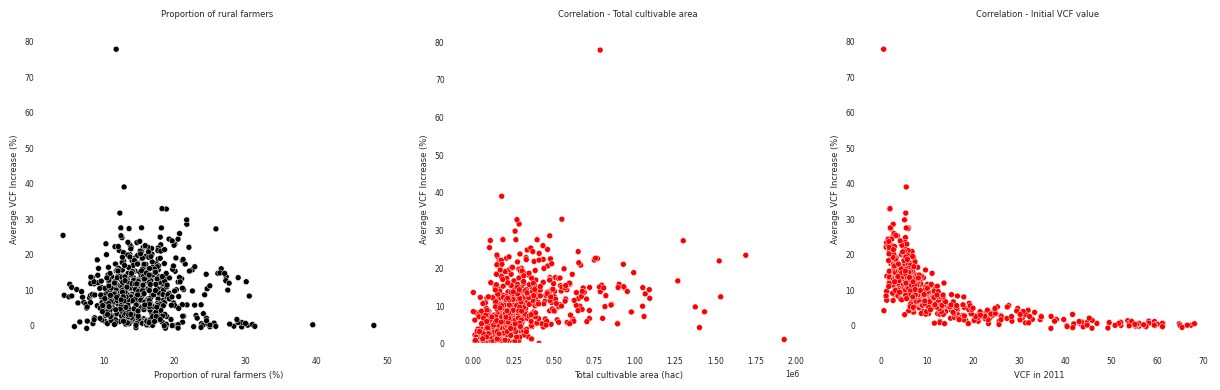

In [ ]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

####################

#plot for Agricultural Workers
ax1.set_xlabel('Proportion of rural farmers (%)')
ax1.set_ylabel('Average VCF Increase (%)')
ax1.set_title('Proportion of rural farmers \n')

#scatterplot for Agricultural Workers
sns.scatterplot(x='Proportion of rural farmers (%)', y='Average VCF increase (%)', data=df_al_vcf_land_2, ax=ax1, marker='o', color='Black', size=1, legend=False)
ax1.set_ylim(bottom=-5)

#calculate correlation coefficient for Agricultural Workers
correlation_agricultural = np.corrcoef(df_al_vcf_land_2['Proportion of rural farmers (%)'], df_al_vcf_land_2['Average VCF increase (%)'])[0, 1]
print(f'Correlation coefficient for proportion of rural farmers: {correlation_agricultural:.2f}', '\n')

####################

#plot for land size
ax2.set_xlabel('Total cultivable area (hac)')
ax2.set_ylabel('Average VCF Increase (%)')
ax2.set_title('Correlation - Total cultivable area \n')

#scatterplot for land size
sns.scatterplot(x='Total cultivable area (hac)', y='Average VCF increase (%)', data=df_al_vcf_land_2, ax=ax2, marker='o', color='Red', size=1, legend=False)
ax2.set_ylim(bottom=0)

#calculate correlation coefficient for land size
correlation_agricultural = np.corrcoef(df_al_vcf_land_2['Total cultivable area (hac)'], df_al_vcf_land_2['Average VCF increase (%)'])[0, 1]
print(f'Correlation coefficient for Total cultivable area: {correlation_agricultural:.2f}', '\n')

####################

#plot for agriculture labour and land size
ax3.set_xlabel('VCF in 2011')
ax3.set_ylabel('Average VCF Increase (%)')
ax3.set_title('Correlation - Initial VCF value \n')

#scatterplot for agriculture labour and land size
sns.scatterplot(x='VCF in 2011', y='Average VCF increase (%)', data=df_al_vcf_land_2, ax=ax3, marker='o', color='Red', size=1, legend=False)
ax3.set_ylim(bottom=-5)

#calculate correlation coefficient for agriculture labour and land size
correlation_agricultural = np.corrcoef(df_al_vcf_land_2['VCF in 2011'], df_al_vcf_land_2['Average VCF increase (%)'])[0, 1]
print(f'Correlation coefficient for Initial VCF value in 2011: {correlation_agricultural:.2f}', '\n')

####################

#remove borders
ax1.spines[['top', 'right']].set_visible(False)
ax1.spines[['bottom', 'left']].set_linewidth(0.25)
ax2.spines[['top', 'right']].set_visible(False)
ax2.spines[['bottom', 'left']].set_linewidth(0.25)
ax3.spines[['top', 'right']].set_visible(False)
ax3.spines[['bottom', 'left']].set_linewidth(0.25)

#show the plots
plt.show()

**Observations**
- **Proportion of rural farmers - Average VCF increase:** the correlation coefficient between these two variables are very close to 0 and hence seemingly unrelated. The points appear very scattered, without a definitive trend.
- **Total cultivable area - Average VCF increase:** there is also a weak positive correlation here, with a coefficient of 0.34. Similarly, a trend is also observed although not necessary as obvious.

</br>

### ``3.2.1.3 testing two-variable correlations with Average VCF increase``###


1.   Proportion of agricultural labour (%): from population census
2.   Total cultivatable land (hac): from Mission Antyodaya dataset
3.   VCF in 2011 (inital vcf values): from vcf dataset


Correlation bw Agriculture Labour and Initial VCF: -0.49 

Correlation bw Total Cultivable area and Initial VCF: -0.33 



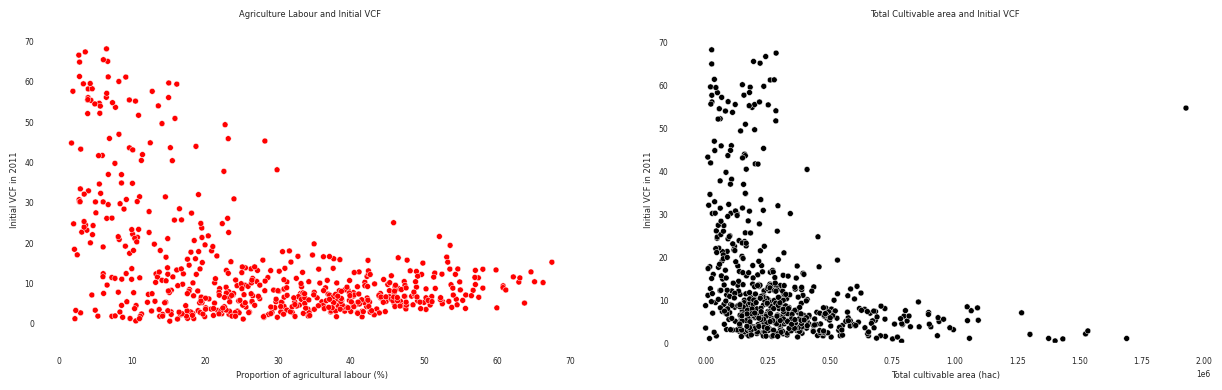

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))

####################

#plot for Agricultural Workers
ax1.set_xlabel('Proportion of agricultural labour (%)')
ax1.set_ylabel('Initial VCF in 2011')
ax1.set_title('Agriculture Labour and Initial VCF \n')

#scatterplot for Agricultural Workers
sns.scatterplot(x='Proportion of agricultural labour (%)', y='VCF in 2011', data=df_al_vcf_land_2, ax=ax1, marker='o', color='Red', size=1, legend=False)
ax1.set_ylim(bottom=-5)

#calculate correlation coefficient for Agricultural Workers
correlation_agricultural = np.corrcoef(df_al_vcf_land_2['Proportion of agricultural labour (%)'], df_al_vcf_land_2['VCF in 2011'])[0, 1]
print(f'Correlation bw Agriculture Labour and Initial VCF: {correlation_agricultural:.2f}', '\n')

####################

#plot for land size
ax2.set_xlabel('Total cultivable area (hac)')
ax2.set_ylabel('Initial VCF in 2011')
ax2.set_title('Total Cultivable area and Initial VCF \n')

#scatterplot for land size
sns.scatterplot(x='Total cultivable area (hac)', y='VCF in 2011', data=df_al_vcf_land_2, ax=ax2, marker='o', color='Black', size=1, legend=False)
ax2.set_ylim(bottom=0)

#calculate correlation coefficient for land size
correlation_agricultural = np.corrcoef(df_al_vcf_land_2['Total cultivable area (hac)'], df_al_vcf_land_2['VCF in 2011'])[0, 1]
print(f'Correlation bw Total Cultivable area and Initial VCF: {correlation_agricultural:.2f}', '\n')

####################

#remove borders
ax1.spines[['top', 'right']].set_visible(False)
ax1.spines[['bottom', 'left']].set_linewidth(0.25)
ax2.spines[['top', 'right']].set_visible(False)
ax2.spines[['bottom', 'left']].set_linewidth(0.25)

#show the plots
plt.show()

**Observations**
- **Proportion of agricultural labour - Initial VCF in 2011:** there is a moderate negative correlation between the two variables, with a coefficient of -0.49. For most of the plots, where initial VCF value is high, the proportion of agricultural labour is also high. This shows that some districts don't follow this trend.
- **Total cultivable land - Initial VCF in 2011:** there is a weak negative correlation here with a coefficient of -0.33. Despite this, a slight trend can be seen from the scatterplot.

</br>

### ``3.2.2 Multiple-variable correlation analysis``###

A Multiple-variable correlation test should show if the average VCF increase is correlated to two or more variables. Environmental issues are, afterall, a highly complex issue and is often affected by many forces. In this section, three-variable correlation coefficients will be calculated to determine if there are strong global trends between several variables.

</br>

#####Multiple Correlation test between:#####

A moderately high coefficient value of 0.62 denotes that these three variables observe somewhat proportional global trends but only for most cases.

1.   **Total cultivable area (hac)**
2.   Initial VCF in 2011
3.   Average VCF increase (%)


In [ ]:
#multiple correlation coefficient D
x1d = df_al_vcf_land_2['Total cultivable area (hac)']
x2d = df_al_vcf_land_2['VCF in 2011']
Yd = df_al_vcf_land_2['Average VCF increase (%)']

#calculate correlation coefficients D
correlation_XY1d = np.corrcoef(x1d, Yd)[0, 1]
correlation_XY2d = np.corrcoef(x2d, Yd)[0, 1]
correlation_X1X2d = np.corrcoef(x1d, x2d)[0, 1]

#calculate multiple correlation coefficient (R) D
multiple_correlation_d = np.sqrt(correlation_XY1d**2 + correlation_XY2d**2 - 2 * correlation_XY1d * correlation_XY2d * correlation_X1X2d)

print(f"MCC Total cultivable area - Initial VCF - average VCF increase (R): {multiple_correlation_d:.2f}")

MCC Total cultivable area - Initial VCF - average VCF increase (R): 0.62


</br>

#####Multiple Correlation test between:#####

A moderately high positive coefficient value of 0.62 denotes that these three variables observe somewhat proportional global trends but only for most cases.

1.   **Proportion of rural farmers (%)**
2.   Initial VCF in 2011
3.   Average VCF increase (%)


In [ ]:
#multiple correlation coefficient C
x1c = df_al_vcf_land_2['Proportion of rural farmers (%)']
x2c = df_al_vcf_land_2['VCF in 2011']
Yc = df_al_vcf_land_2['Average VCF increase (%)']

#calculate correlation coefficients C
correlation_XY1c = np.corrcoef(x1c, Yc)[0, 1]
correlation_XY2c = np.corrcoef(x2c, Yc)[0, 1]
correlation_X1X2c = np.corrcoef(x1c, x2c)[0, 1]

#calculate multiple correlation coefficient (R) C
multiple_correlation_c = np.sqrt(correlation_XY1c**2 + correlation_XY2c**2 - 2 * correlation_XY1c * correlation_XY2c * correlation_X1X2c)

print(f"MCC Proportion of rural farmers - Initial VCF - average VCF increase (R): {multiple_correlation_c:.2f}")

MCC Proportion of rural farmers - Initial VCF - average VCF increase (R): 0.62


</br>

#####Multiple Correlation test between:#####

A weak positve correlation (0.36) denotes a general observerable trend globally but is not always proportional.

1.   **Proportion of rural farmers (%)**
2.   **Total cultivable area (hac)**
3.   Average VCF increase (%)



In [ ]:
#multiple correlation coefficient A
x1a = df_al_vcf_land_2['Proportion of rural farmers (%)']
x2a = df_al_vcf_land_2['Total cultivable area (hac)']
Ya = df_al_vcf_land_2['Average VCF increase (%)']

#calculate correlation coefficients A
correlation_XY1a = np.corrcoef(x1a, Ya)[0, 1]
correlation_XY2a = np.corrcoef(x2a, Ya)[0, 1]
correlation_X1X2a = np.corrcoef(x1a, x2a)[0, 1]

#calculate multiple correlation coefficient (R) A
multiple_correlation_a = np.sqrt(correlation_XY1a**2 + correlation_XY2a**2 - 2 * correlation_XY1a * correlation_XY2a * correlation_X1X2a)

print(f"MCC Proportion of rural farmers - Total cultivable area - average VCF increase (R): {multiple_correlation_a:.2f}")

MCC Proportion of rural farmers - Total cultivable area - average VCF increase (R): 0.36


</br>

#####Multiple Correlation test between:#####

A moderate positive coefficient value of 0.56 denotes that these three variables observe somewhat proportional global trends but not for many cases.

1.   **Proportion of agricultural labour (%)**
2.   Initial VCF in 2011
3.   Average VCF increase (%)


In [ ]:
#multiple correlation coefficient B
x1b = df_al_vcf_land_2['Proportion of agricultural labour (%)']
x2b = df_al_vcf_land_2['VCF in 2011']
Yb = df_al_vcf_land_2['Average VCF increase (%)']

#calculate correlation coefficients B
correlation_XY1b = np.corrcoef(x1b, Yb)[0, 1]
correlation_XY2b = np.corrcoef(x2b, Yb)[0, 1]
correlation_X1X2b = np.corrcoef(x1b, x2b)[0, 1]

#calculate multiple correlation coefficient (R) B
multiple_correlation_b = np.sqrt(correlation_XY1b**2 + correlation_XY2b**2 - 2 * correlation_XY1b * correlation_XY2b * correlation_X1X2b)

print(f"MCC Proportion of agricultural labour - Initial VCF - average VCF increase (R): {multiple_correlation_b:.2f}")

MCC Proportion of agricultural labour - Initial VCF - average VCF increase (R): 0.56


</br>

#####Multiple Correlation test between all variables:#####

Globally, these variable show a moderate positive correlation to each other. However, they will be plotted on a chloropleth to understand if there is any spatial significance in these values.

1.   Total cultivable area (hac)
2.   Initial VCF in 2011
3.   Proportion of rural farmers (%)
3.   Average VCF increase (%)


In [ ]:
from scipy.stats import pearsonr

Y = df_al_vcf_land_2['Average VCF increase (%)'].values
X1 = df_al_vcf_land_2['District land size (area sqmm)'].values
X2 = df_al_vcf_land_2['VCF in 2011'].values
X3 = df_al_vcf_land_2['Proportion of rural farmers (%)'].values

# Calculate correlation coefficients
correlation_XY1 = np.corrcoef(X1, Y)[0, 1]
correlation_XY2 = np.corrcoef(X2, Y)[0, 1]
correlation_XY3 = np.corrcoef(X3, Y)[0, 1]
correlation_X1X2 = np.corrcoef(X1, X2)[0, 1]
correlation_X1X3 = np.corrcoef(X1, X3)[0, 1]
correlation_X2X3 = np.corrcoef(X2, X3)[0, 1]

# Calculate partial correlation coefficient (R_{X1X2X3})
partial_corr_X1X2X3, _ = pearsonr(X1 - correlation_X1X2 * X2 - correlation_X1X3 * X3, X2 - correlation_X1X2 * X1 - correlation_X2X3 * X3)

# Calculate multiple correlation coefficient (R)
numerator = correlation_XY1**2 + correlation_XY2**2 + correlation_XY3**2 - 2 * correlation_XY1 * correlation_XY2 * correlation_X1X2 - 2 * correlation_XY1 * correlation_XY3 * correlation_X1X3 - 2 * correlation_XY2 * correlation_XY3 * correlation_X2X3 + 3 * correlation_XY1 * correlation_XY2 * correlation_XY3 * partial_corr_X1X2X3
denominator = 1 - correlation_X1X2**2 - correlation_X1X3**2 - correlation_X2X3**2 + 2 * partial_corr_X1X2X3**2

multiple_correlation = np.sqrt(numerator / denominator)

print(f"Multiple Correlation Coefficient (R): {multiple_correlation:.2f}")

Multiple Correlation Coefficient (R): 0.39


From this part of the analysis, the four-variable analysis shows that there are positive trends between the variables but they are not proportionately observed in every district. It could mean that the independent variables ( initial VCF in 2011, cultivable land, proportion of agricultural labour and proportion of rural farmers) do not affect certain districts as much as others or that other factors in society impact certain districts more than the independent variables. Such an issue is highly complex, so this is not unexpected.

****

# 3.3.0 Managing missing data

The Mission Antyodaya dataset is not as consistent as the population census as there is data that is missing for several districts. However, most of these districts are amongst neighbours that do have data and some of them are within groups of districts with similar values. Hence, a K-Nearest Neighbours method to impute missing data is appropriate.

**Training data used to impute missing total cultivable area:**
district land size and proportion of agricultural labour as these variables are often associated together and they are moderately correlated (0.58).

**Training data used to impute proportion of rural farmers:**
total cultivable land area and total marginal agricultural workers were used as rural farmers are often included in the data of marginal agricultural workers as well. Cultivable land was used as it is also associated with high agricultural activity which the hypothesis assumed to be proportional to the proportion of agricultural and rural farmers.

</br>

### ``3.3.0.1 [Total cultivable area (hac)] Impute with K-Nearest Neighbours method``###

In [ ]:
#filling in missing values
from sklearn.neighbors import KNeighborsRegressor

In [ ]:
df_al_vcf_land['Total marginal agricultural workers (#)'] = pca_2011_original['pc11_pca_marg_al_p']
df_al_vcf_land.head()

,District ID,District name,Proportion of agricultural labour (%),Average VCF increase (%),VCF in 2011,Proportion of rural farmers (%),Total cultivable area (hac),District land size (area sqmm),Total marginal agricultural workers (#)
0,1,Kupwara,24.778664,2.016496,28.426696,NaN,NaN,2.571146e+05,46925
1,2,Badgam,17.047834,3.331161,12.234603,14.503717,57948.175070,1.218271e+05,25070
2,3,Leh(Ladakh),2.191025,8.164468,1.098495,20.572685,15956.018711,4.884437e+06,1052
3,4,Kargil,7.254256,12.182668,1.695090,14.530522,43435.821971,1.354654e+06,3239
4,5,Punch,19.569002,2.122981,23.615615,13.187678,156668.078084,1.746596e+05,25666


In [ ]:
#drop missing data for training
df_al_vcf_land_T = df_al_vcf_land.dropna(axis=0)
y_var = 'Total cultivable area (hac)'

#set training data
x_train = df_al_vcf_land_T[['District land size (area sqmm)', 'Proportion of agricultural labour (%)']]
y_train = df_al_vcf_land_T[y_var]

#set number of neighbors
k = 10
knnreg = KNeighborsRegressor(n_neighbors=k)

#fit the regressor - make sure your numpy arrays are the right shape!
knnreg.fit(x_train, y_train)

#evaluate the outcome on the train set using R^2
r2_train = knnreg.score(x_train, y_train)

print(f'kNN model with {k} neighbors gives R^2 on the train set: {r2_train}')

kNN model with 10 neighbors gives R^2 on the train set: 0.6135107592070421


In [ ]:
#get rows that have missing values
rows_missing = df_al_vcf_land[df_al_vcf_land.isna().any(axis=1)]

#make new dataframe out of rows with missing values
df_missing = pd.DataFrame(rows_missing)


In [ ]:
#x_test and y_test
x_test = df_missing[['District land size (area sqmm)', 'Proportion of agricultural labour (%)']]
y_test = knnreg.predict(x_test)
#df2011_missing['Average VCF percentage increase (%)']
print ('Total cultivable area (hac): {}'.format(y_test))

Total cultivable area (hac): [159130.07911812 186156.75011186  51391.57712905 200513.33020928
 167591.42090113  51391.57712905 403656.0698987   70943.55015916
  51391.57712905  51391.57712905  51391.57712905  51391.57712905
  51391.57712905  51391.57712905  51391.57712905  51391.57712905
  51391.57712905 239940.36360905 275052.82464117 206480.60350674
 205745.11578126 193897.04156889 158199.52904885  51391.57712905
 325922.70711408  51391.57712905  51391.57712905  51391.57712905
  51391.57712905  51391.57712905  51391.57712905 391810.0708501
  51391.57712905  51391.57712905  51391.57712905  51391.57712905
  51391.57712905  51391.57712905 137744.95016385 203478.11783731
 150838.42223886]


In [ ]:
r2_test = knnreg.score(x_test, y_test)
print(f'kNN model with {k} neighbors gives R^2 on the test set: {r2_test}')

kNN model with 10 neighbors gives R^2 on the test set: 1.0


In [ ]:
df_missing[y_var] = y_test
df_missing.head()

,District ID,District name,Proportion of agricultural labour (%),Average VCF increase (%),VCF in 2011,Proportion of rural farmers (%),Total cultivable area (hac),District land size (area sqmm),Total marginal agricultural workers (#)
0,1,Kupwara,24.778664,2.016496,28.426696,NaN,159130.079118,257114.563426,46925
8,9,Bandipore,22.021605,1.157874,17.413843,NaN,186156.750112,253894.622048,23459
9,10,Srinagar,2.556067,1.306951,13.757675,NaN,51391.577129,46644.782191,3895
15,16,Doda,8.030307,1.696178,34.106979,16.864347,200513.330209,234991.794964,8261
19,20,Reasi,2.769278,2.359121,24.062298,NaN,167591.420901,207846.497938,2716


In [ ]:
df_al_vcf_land_N = pd.concat([df_al_vcf_land_T, df_missing], ignore_index=True)
df_al_vcf_land_N.head()

,District ID,District name,Proportion of agricultural labour (%),Average VCF increase (%),VCF in 2011,Proportion of rural farmers (%),Total cultivable area (hac),District land size (area sqmm),Total marginal agricultural workers (#)
0,2,Badgam,17.047834,3.331161,12.234603,14.503717,57948.175070,1.218271e+05,25070
1,3,Leh(Ladakh),2.191025,8.164468,1.098495,20.572685,15956.018711,4.884437e+06,1052
2,4,Kargil,7.254256,12.182668,1.695090,14.530522,43435.821971,1.354654e+06,3239
3,5,Punch,19.569002,2.122981,23.615615,13.187678,156668.078084,1.746596e+05,25666
4,6,Rajouri,8.255417,2.819744,20.768336,23.011949,75651.774652,2.693616e+05,17868


</br>

### ``3.3.0.2 [Proportion of rural farmers (%)] Impute with K-Nearest Neighbours method``###

In [ ]:
df_al_vcf_land_T = df_al_vcf_land_N.dropna(axis=0)

y_var = 'Proportion of rural farmers (%)'


#set training data
x_train = df_al_vcf_land_T[['Total cultivable area (hac)', 'Total marginal agricultural workers (#)']]
y_train = df_al_vcf_land_T[y_var]

#set number of neighbors
k = 5
knnreg = KNeighborsRegressor(n_neighbors=k)

#fit the regressor - make sure your numpy arrays are the right shape!
knnreg.fit(x_train, y_train)

#evaluate the outcome on the train set using R^2
r2_train = knnreg.score(x_train, y_train)

print(f'kNN model with {k} neighbors gives R^2 on the train set: {r2_train}')

kNN model with 5 neighbors gives R^2 on the train set: 0.29269730870093913


In [ ]:
#get rows that have missing values
rows_missing = df_al_vcf_land_N[df_al_vcf_land_N.isna().any(axis=1)]

#make new dataframe out of rows with missing values
df_missing = pd.DataFrame(rows_missing)


In [ ]:
#x_test and y_test
x_test = df_missing[['Total cultivable area (hac)', 'Total marginal agricultural workers (#)']]
y_test = knnreg.predict(x_test)
#df2011_missing['Average VCF percentage increase (%)']
print ('Proportion of rural farmers (%): {}'.format(y_test))

Proportion of rural farmers (%): [ 9.53944498 14.30262166 15.49562575 14.29129099 15.49562575 12.74651138
 15.49562575 15.49562575 15.49562575 15.49562575 15.49562575 13.21374881
 14.15155006 14.15155006 15.15167745 21.0284466  15.4978574  16.12842836
 12.57533396 20.79978396 13.49645982 12.18996601 14.7912615  12.18996601
 15.01696525 14.15155006 14.37220859 14.15155006 12.65925928 13.40507594
 12.82178802 13.21374881 15.49562575 15.49562575 15.49562575 15.49562575
 18.25233076 21.44486731 17.93445033]


In [ ]:
r2_test = knnreg.score(x_test, y_test)
print(f'kNN model with {k} neighbors gives R^2 on the test set: {r2_test}')

kNN model with 5 neighbors gives R^2 on the test set: 1.0


In [ ]:
df_missing[y_var] = y_test
df_missing.head()

,District ID,District name,Proportion of agricultural labour (%),Average VCF increase (%),VCF in 2011,Proportion of rural farmers (%),Total cultivable area (hac),District land size (area sqmm),Total marginal agricultural workers (#)
599,1,Kupwara,24.778664,2.016496,28.426696,9.539445,159130.079118,257114.563426,46925
600,9,Bandipore,22.021605,1.157874,17.413843,14.302622,186156.750112,253894.622048,23459
601,10,Srinagar,2.556067,1.306951,13.757675,15.495626,51391.577129,46644.782191,3895
603,20,Reasi,2.769278,2.359121,24.062298,14.291291,167591.420901,207846.497938,2716
604,55,Chandigarh,0.417434,7.836952,9.716062,15.495626,51391.577129,11123.680724,2773


In [ ]:
df_al_vcf_land_NN = pd.concat([df_al_vcf_land_T, df_missing], ignore_index=True)
df_al_vcf_land_NN.head()

,District ID,District name,Proportion of agricultural labour (%),Average VCF increase (%),VCF in 2011,Proportion of rural farmers (%),Total cultivable area (hac),District land size (area sqmm),Total marginal agricultural workers (#)
0,2,Badgam,17.047834,3.331161,12.234603,14.503717,57948.175070,1.218271e+05,25070
1,3,Leh(Ladakh),2.191025,8.164468,1.098495,20.572685,15956.018711,4.884437e+06,1052
2,4,Kargil,7.254256,12.182668,1.695090,14.530522,43435.821971,1.354654e+06,3239
3,5,Punch,19.569002,2.122981,23.615615,13.187678,156668.078084,1.746596e+05,25666
4,6,Rajouri,8.255417,2.819744,20.768336,23.011949,75651.774652,2.693616e+05,17868


</br>

### ``3.3.0.2 Drop island data``###
Data from districts 638, 639 and 640 will be dropped as they are island districts. The island economies don't function the same way as the mainland districts. Furthermore, VCF data for these areas are unavailable for every year and they are geographically too far apart from the rest of the datasets to perform a K-NN imputation. Hence, the island districts will be dropped.

In [ ]:
df_al_vcf_land_NN = df_al_vcf_land_NN.dropna(subset=['Average VCF increase (%)'])
df_al_vcf_land_NN.tail()

,District ID,District name,Proportion of agricultural labour (%),Average VCF increase (%),VCF in 2011,Proportion of rural farmers (%),Total cultivable area (hac),District land size (area sqmm),Total marginal agricultural workers (#)
632,603,Chennai,0.752436,1.541544,8.231048,13.213749,51391.577129,14805.602126,79234
633,634,Yanam,19.832936,5.798488,12.527119,15.495626,51391.577129,1528.384445,3485
634,635,Puducherry,14.911593,6.262534,11.448202,15.495626,51391.577129,24702.620478,3101
635,636,Mahe,0.694797,9.268224,22.476636,15.495626,51391.577129,691.338255,659
636,637,Karaikal,19.146133,11.417878,10.124498,15.495626,51391.577129,13369.656182,6278


</br>

### ``3.6.2 Overview``###

For the statistical clustering, the variable 'District land size (area sqmm) will be dropped due to the fact high variation of India's terrain. Not every square area of land of a large district is usable for agriculture. For instance, a large district like those in the Ladakh area are generally mountainous and not necessarily suitable for agriculture. Coincidentally, the total cultivable area for these districts are low. Hence, district size is not a good indicator for possible agricultural activity and this variable will not be analysed in the statistical clustering.

<ipython-input-49-a144cb84c114>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_al_vcf_land_NN[common_column] = df_al_vcf_land_NN[common_column].astype(int)


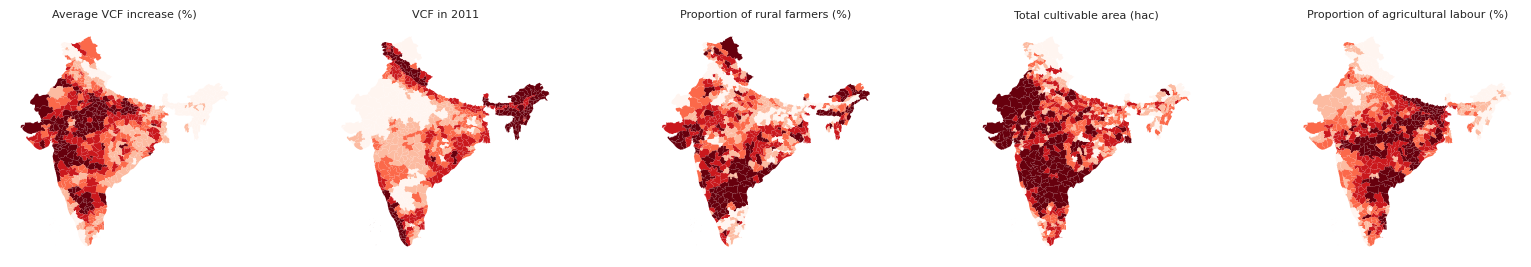

In [ ]:
#merging shp file and csv, plotting Average VCF percentage increase

dist.to_crs(epsg=4326, inplace=True)

common_column = 'District ID'

#convert to int
dist[common_column] = dist[common_column].astype(int)
df_al_vcf_land_NN[common_column] = df_al_vcf_land_NN[common_column].astype(int)

merged_data = pd.merge(dist, df_al_vcf_land_NN, how='left', left_on=common_column, right_on=common_column)
merged_data.reset_index(drop=True, inplace=True)
merged_data = merged_data.dropna(subset=['Average VCF increase (%)'])

f, axs = plt.subplots(nrows=1, ncols=5, figsize=(20, 3))
axs = axs.flatten()

for i, col in enumerate(columns):
    ax = axs[i]
    merged_data.plot(column=col, ax=ax, scheme='Quantiles', linewidth=0, cmap='Reds', alpha=1)
    ax.set_axis_off()
    ax.set_title(col, fontsize=8)  # Set the font size here
    ax.tick_params(left=False, right=False, top=False, bottom=False, labelleft=False, labelright=False, labeltop=False, labelbottom=False)

plt.show()

These variables all show a spatial trend where one area is more clustered with high values while another area is clustered with low values. However, it is observed that the highs and lows of each variable do not overlap everywhere, which implies that the relationships between these variables are not similar across the whole of India. Some areas in the east, where areas such as Meghalaya, Assam, Nagaland, Manipur, Tripura, Mizoram and Arunachal Pradesh are, appears to show a relationship between the variables parallel to the hypothesis. An analysis into the global spatial autocorrelation of these variables will be conducted to understand if values of districts are affected by their neighbours.

***

# 3.4 Global Spatial Autocorrelation



To understand if these variables have a spatial trend to them, the spatial lag and Moran's I were plotted to determine how significant are the observations geographically or if they are merely coincidental.

</br>

### ``3.4.1 Spatial lag and Moran's I: Average VCF increase (%)``###

In [ ]:
%time w = weights.Queen.from_dataframe(merged_data, idVariable='District ID')

#row standardize the matrix
w.transform = 'R'
w[1]

<timed exec>:1: FutureWarning: `idVariable` is deprecated and will be removed in future. Use `ids` instead.


CPU times: user 9.98 s, sys: 573 ms, total: 10.6 s
Wall time: 12.8 s
('WARNING: ', 55, ' is an island (no neighbors)')
('WARNING: ', 71, ' is an island (no neighbors)')
('WARNING: ', 88, ' is an island (no neighbors)')
('WARNING: ', 342, ' is an island (no neighbors)')
('WARNING: ', 494, ' is an island (no neighbors)')
('WARNING: ', 495, ' is an island (no neighbors)')
('WARNING: ', 496, ' is an island (no neighbors)')
('WARNING: ', 528, ' is an island (no neighbors)')
('WARNING: ', 587, ' is an island (no neighbors)')


/usr/local/lib/python3.10/dist-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 31 disconnected components.
 There are 9 islands with ids: 55, 71, 88, 342, 494, 495, 496, 528, 587.
  W.__init__(self, neighbors, ids=ids, **kw)


{8: 0.5, 9: 0.5}

In [ ]:
def spatial_lag(md_col, sl_col, ax):

  lag_ = libpysal.weights.spatial_lag.lag_spatial(w, merged_data[md_col])
  merged_data[sl_col] = lag_

  merged_data.plot(column=sl_col, cmap='Reds', linewidth=0.2, ax=ax, edgecolor='#ffffff', legend=False)
  sm= merged_data.plot(column=sl_col, cmap='Reds', linewidth=0.2, ax=ax, edgecolor= '#ffffff', legend=False)

  #legend
  ax.set_title(sl_col, fontdict={'fontsize': '5', 'fontweight': '1'})
  cbar = plt.colorbar(ax.collections[0], ax=ax, fraction=0.015, pad=0.01)
  cbar.ax.tick_params(labelsize=10)
  cbar.outline.set_visible(False)

  ax.set_axis_off()


In [ ]:
def morans_i(md_col, ax):
  #check for missing values
  missing_values = merged_data[md_col].isnull().any()

  if missing_values:
      print("Missing values found. Imputing with mean value.")

      # Impute missing values with mean
      mean_value = np.nanmean(merged_data[md_col])
      merged_data[md_col] = merged_data[md_col].fillna(mean_value)

  #calculate Moran's I
  moran = Moran(merged_data[md_col], w)
  fig, ax = moran_scatterplot(moran, aspect_equal=False, ax=ax, scatter_kwds={'color': 'red', 'edgecolor': 'white', 's':5}, fitline_kwds={'color': 'black', 'linewidth': 0.5})

  ax.set_xlabel('Spatial Lag', fontsize=5)
  ax.set_ylabel('Moran\'s I', fontsize=5)

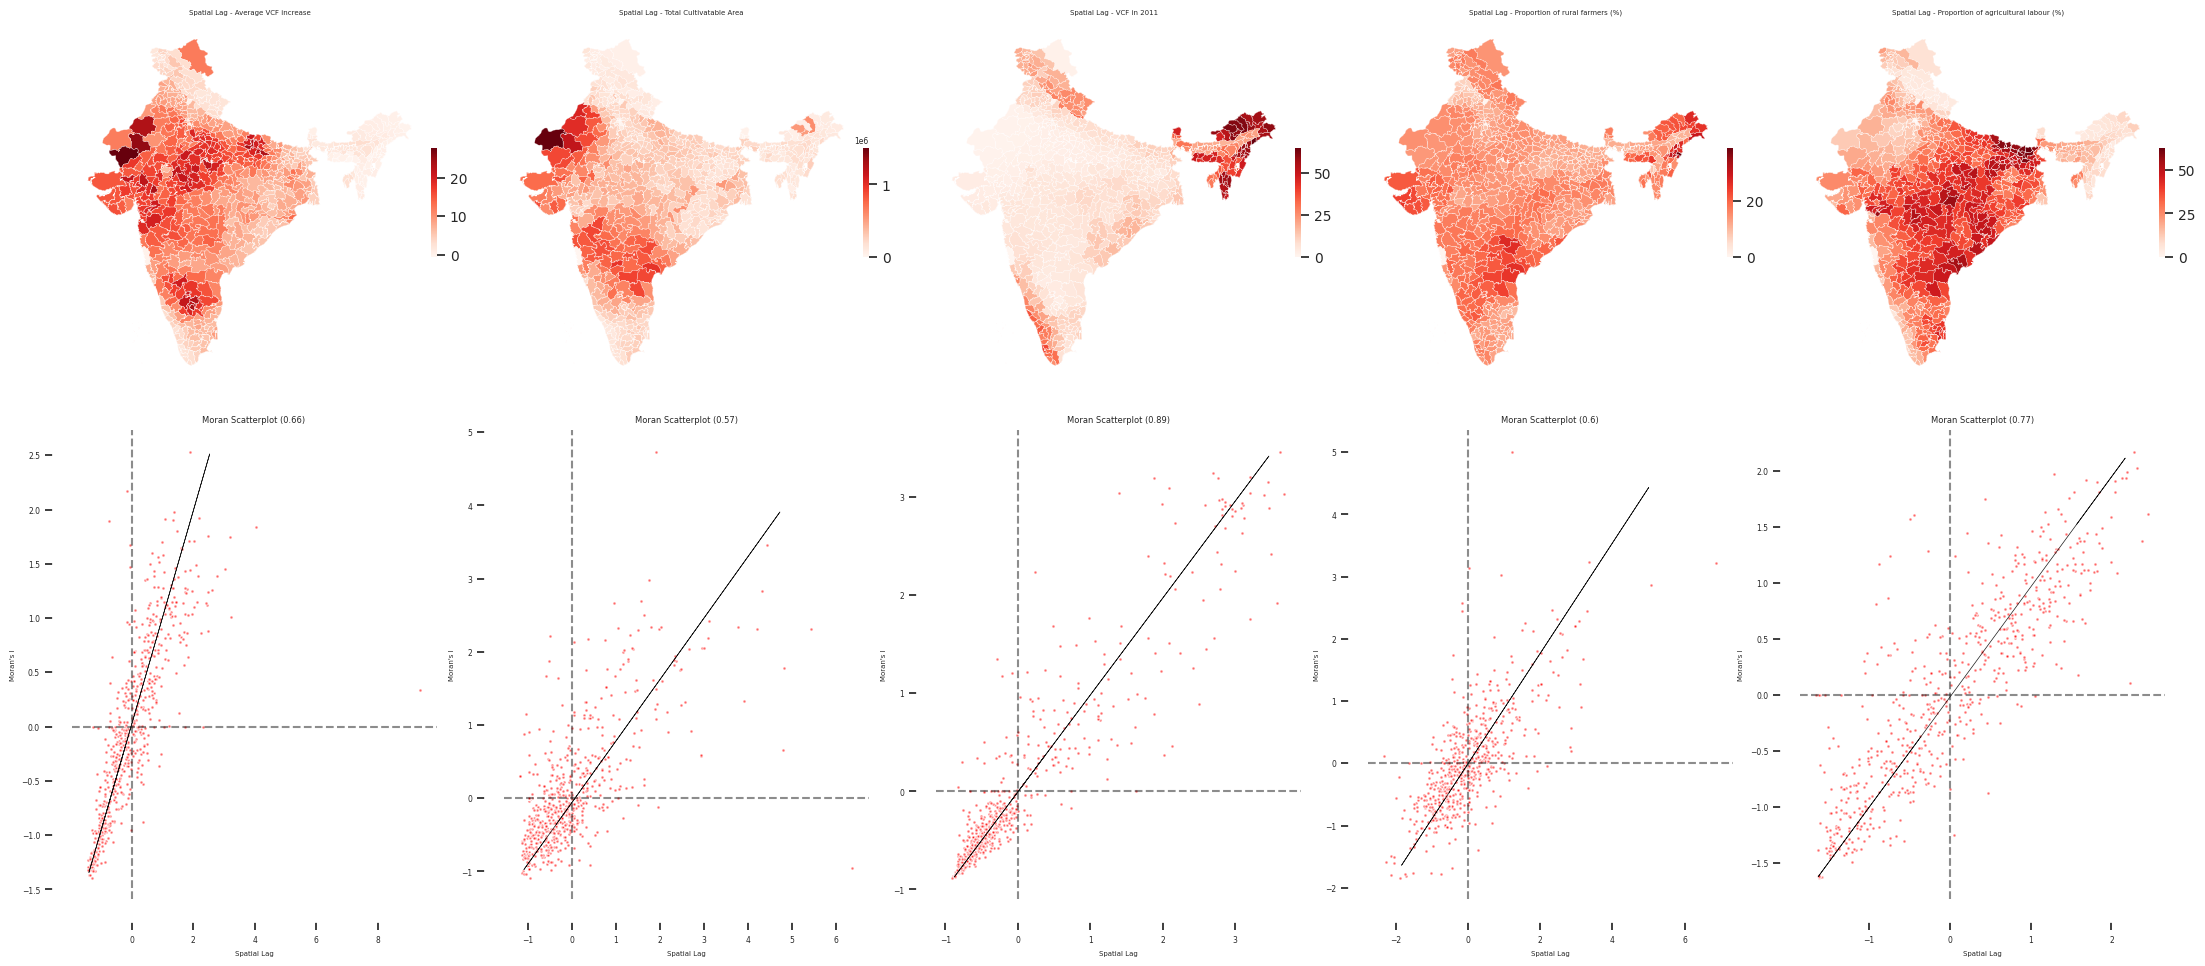

In [ ]:
f, ((ax1, ax2, ax3, ax4, ax5), (ax6, ax7, ax8, ax9, ax10)) = plt.subplots(nrows=2, ncols=5, figsize=(22, 10))

spatial_lag('Average VCF increase (%)', 'Spatial Lag - Average VCF increase', ax1)
spatial_lag('Total cultivable area (hac)', 'Spatial Lag - Total Cultivatable Area', ax2)
spatial_lag('VCF in 2011', 'Spatial Lag - VCF in 2011', ax3)
spatial_lag('Proportion of rural farmers (%)', 'Spatial Lag - Proportion of rural farmers (%)', ax4)
spatial_lag('Proportion of agricultural labour (%)', 'Spatial Lag - Proportion of agricultural labour (%)', ax5)

morans_i('Average VCF increase (%)', ax6)
morans_i('Total cultivable area (hac)', ax7)
morans_i('VCF in 2011', ax8)
morans_i('Proportion of rural farmers (%)', ax9)
morans_i('Proportion of agricultural labour (%)', ax10)

plt.tight_layout()
plt.show()

'Moran's I' value for each variable:
- Average VCF increase (%): 0.67
- Initial VCF in 2011: 0.89
- Total cultivable land (hac): 0.58
- Proportion of rural farmers (%): 0.61
- Proportion of agricultural labour (%): 0.61





The spatial lag and 'Moran's I' analyses showed high global spatial autocorrelation for all variables, considering all values are positive - a high likelihood that the spatial trends of these variables are not random. However, from the spatial lag and chloropleths, it can be observed that not all areas show significant trends and the areas of high values of one area do not overlap with high values of other variables, and vice versa. To understand which areas are more significant in terms of spatial trends for each variable, a local spatial autocorrelation analysis should be conducted to further build on these observations.


***

</br>

# 3.5 Local Spatial Autocorrelation

The Local Indicators of Spatial Association (LISA) analysis was used to discover any local spatial autocorrelation. While the hypothesis vaguely generalised that the correlation between all kinds of agricultural labour is inversely proportional to the average VCF increase, the chloropleths and correlation graphs above depict different trends for different areas of India. Hence, it would be reasonable to do a LISA analysis to discover where trends are more spatially significant.

The LISA is done for the variables:
- Average VCF increase (%)
- Initial VCF in 2011
- Total cultivable area (hac)
- Proportion of rural farmers (%)
- Proportion of agricultural labour (%)

</br>

### ``3.5.1 LISA for Average VCF increase``###

In [ ]:
merged_data.reset_index(drop=True, inplace=True)

In [ ]:
def getLISA1(meas_var, ax):
  std_meas_var = 'std ' + meas_var
  w_meas_var = 'w ' + meas_var


  merged_data[std_meas_var] = (merged_data[meas_var] - merged_data[meas_var].mean()) / merged_data[meas_var].std()
  merged_data[w_meas_var] = weights.lag_spatial(w, merged_data[std_meas_var])


  # Plot values
  sns.regplot(x=std_meas_var, y=w_meas_var, data=merged_data, ci=None,
              scatter_kws={'s': 5, 'color': 'red', 'edgecolor': 'white', 'linewidth': 1}, line_kws={'color': 'grey', 'linewidth': 1.5}, ax=ax)

  # Add vertical and horizontal lines
  ax.axvline(0, c='k', alpha=0.2)
  ax.axhline(0, c='k', alpha=0.2)

  ax.text(1.5, 1.5, "HH", fontsize=10)
  ax.text(1.5, -1.5, "HL", fontsize=10)
  ax.text(-1.5, 1.5, "LH", fontsize=10)
  ax.text(-1.5, -1.5, "LL", fontsize=10)

  ax.spines[['top', 'right', 'bottom', 'left']].set_visible(False)

In [ ]:
def getLISA2(meas_var, ax):

  merged_data_temp = pd.DataFrame()
  merged_data_temp[meas_var] = merged_data[meas_var].copy()

  lisa = esda.Moran_Local(merged_data_temp[meas_var], w)
  # Break observations into significant or not
  merged_data['significant'] = lisa.p_sim < 0.05
  # Store the quadrant they belong to
  merged_data['quadrant'] = lisa.q

  lisa_cluster(lisa, merged_data, ax=ax)

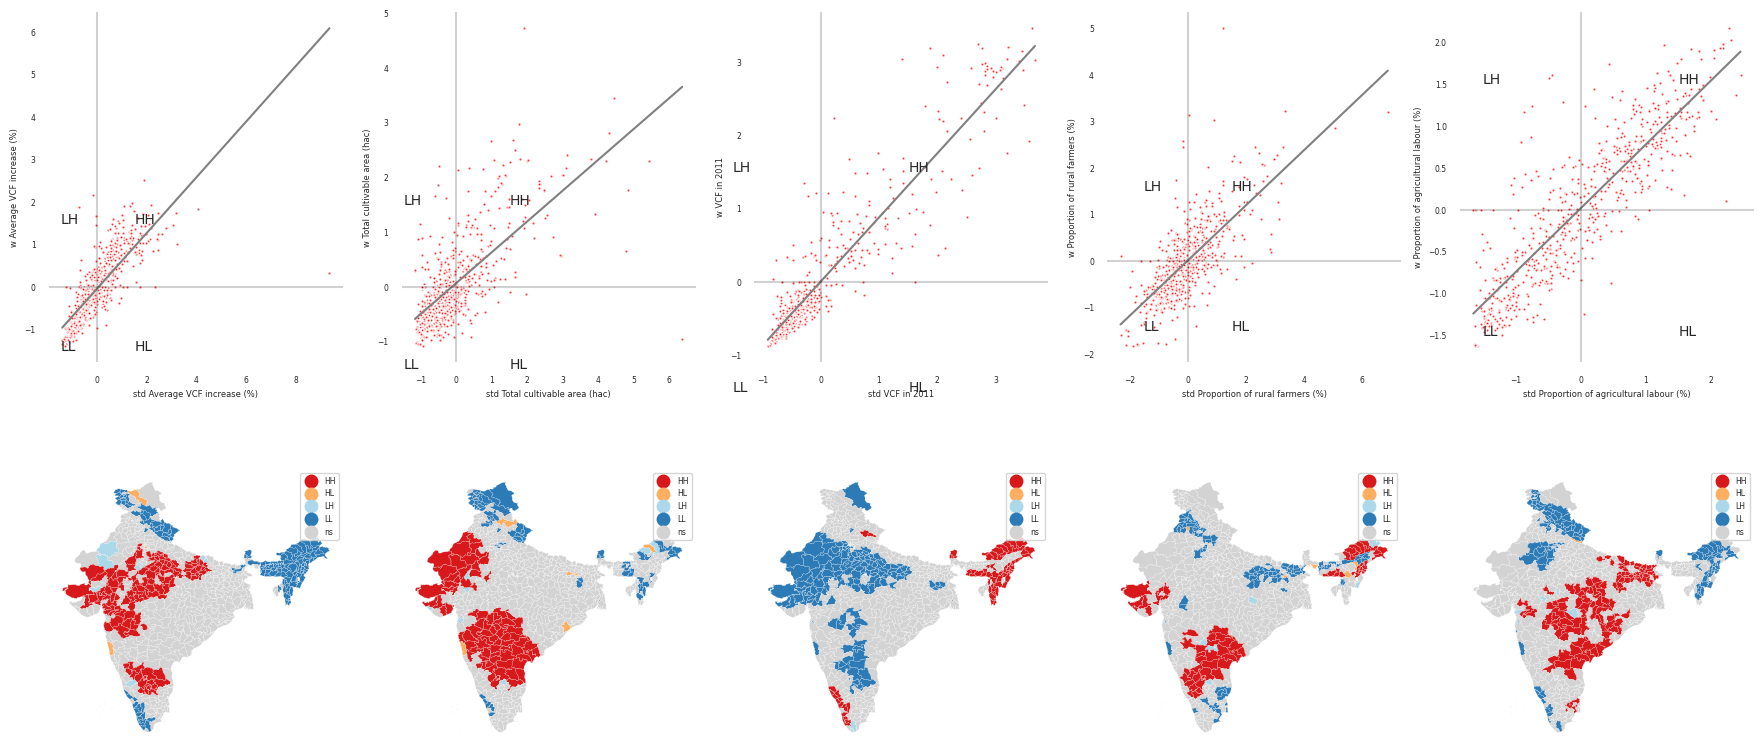

In [ ]:
f, ((ax1, ax2, ax3, ax4, ax5), (ax6, ax7, ax8, ax9, ax10)) = plt.subplots(nrows=2, ncols=5, figsize=(22, 10))

getLISA1('Average VCF increase (%)', ax1)
getLISA1('Total cultivable area (hac)', ax2)
getLISA1('VCF in 2011', ax3)
getLISA1('Proportion of rural farmers (%)', ax4)
getLISA1('Proportion of agricultural labour (%)', ax5)

getLISA2('Average VCF increase (%)', ax6)
getLISA2('Total cultivable area (hac)', ax7)
getLISA2('VCF in 2011', ax8)
getLISA2('Proportion of rural farmers (%)', ax9)
getLISA2('Proportion of agricultural labour (%)', ax10)


The LISA analysis shows that each of these variables are spatially significant but in different ways. Some of these highlighted areas overlap but not all. FUrthermore, these plots imply that the relationships between all kinds of agricultural labour and the growth of forest cover is not similarly observed throughout all districts. This helps explain the low correlation values briefly analysed in 3.2.

<b>

***

</b>




#3.6 Statistical clustering


From the LISA analysis, it is clear that some values in each variable are more significant that others and that the trend highlighted in the hypothesis may not be relevant or observed in every district of India due to other factors that may contribute to the deforestation problem or policies implemented in some districts since the awareness of this environmental issue. The K-Means clustering approach can help group similar values together to paint a better picture of the spatial trends across the country.

</br>

### ``3.6.1 Reorganising dataframes``###

Reorganising the dataframes to be used for the following statistical clustering

In [ ]:
df_al_vcf_land_NNN = df_al_vcf_land_NN.reset_index(drop=True)

df_al_vcf_land_SC = df_al_vcf_land_NNN.sort_values(by='District ID', ascending=True)
df_al_vcf_land_SC.reset_index(drop=True, inplace=True)

In [ ]:
column_to_remove = 'Total marginal agricultural workers (#)'

if column_to_remove in df_al_vcf_land_NN.columns:
    df_al_vcf_land_SC = df_al_vcf_land_NN.drop(column_to_remove, axis=1)

df_al_vcf_land_SC.head()

,District ID,District name,Proportion of agricultural labour (%),Average VCF increase (%),VCF in 2011,Proportion of rural farmers (%),Total cultivable area (hac),District land size (area sqmm)
0,2,Badgam,17.047834,3.331161,12.234603,14.503717,57948.175070,1.218271e+05
1,3,Leh(Ladakh),2.191025,8.164468,1.098495,20.572685,15956.018711,4.884437e+06
2,4,Kargil,7.254256,12.182668,1.695090,14.530522,43435.821971,1.354654e+06
3,5,Punch,19.569002,2.122981,23.615615,13.187678,156668.078084,1.746596e+05
4,6,Rajouri,8.255417,2.819744,20.768336,23.011949,75651.774652,2.693616e+05


Island districts were excluded from this analysis as their economies and labour forces work differently. Furthermore, there is a lack of VCF data for these districts across all years.

In [ ]:
merged_sc = pd.merge(dist, df_al_vcf_land_SC, how='left', left_on=common_column, right_on=common_column)
merged_ksc = merged_sc.dropna(subset=['Average VCF increase (%)'])
merged_ksc.tail()

,pc11_s_id,District ID,d_name,geometry,District name,Proportion of agricultural labour (%),Average VCF increase (%),VCF in 2011,Proportion of rural farmers (%),Total cultivable area (hac),District land size (area sqmm)
632,33,633,Tiruppur,"POLYGON ((77.22571 11.34867, 77.22679 11.34862...",Tiruppur,19.455478,7.577061,5.470032,10.169463,358211.903737,429092.836431
633,34,634,Yanam,"MULTIPOLYGON (((82.25762 16.70905, 82.25847 16...",Yanam,19.832936,5.798488,12.527119,15.495626,51391.577129,1528.384445
634,34,635,Puducherry,"MULTIPOLYGON (((79.69014 11.80531, 79.68936 11...",Puducherry,14.911593,6.262534,11.448202,15.495626,51391.577129,24702.620478
635,34,636,Mahe,"MULTIPOLYGON (((75.54228 11.70417, 75.54178 11...",Mahe,0.694797,9.268224,22.476636,15.495626,51391.577129,691.338255
636,34,637,Karaikal,"MULTIPOLYGON (((79.74007 10.92058, 79.73995 10...",Karaikal,19.146133,11.417878,10.124498,15.495626,51391.577129,13369.656182


</br>

### ``3.6.6 Regionalisation of variables``

Regionalisation of the clusters was used to group clusters with similar values for each variable to show how different regions show different trends across India.

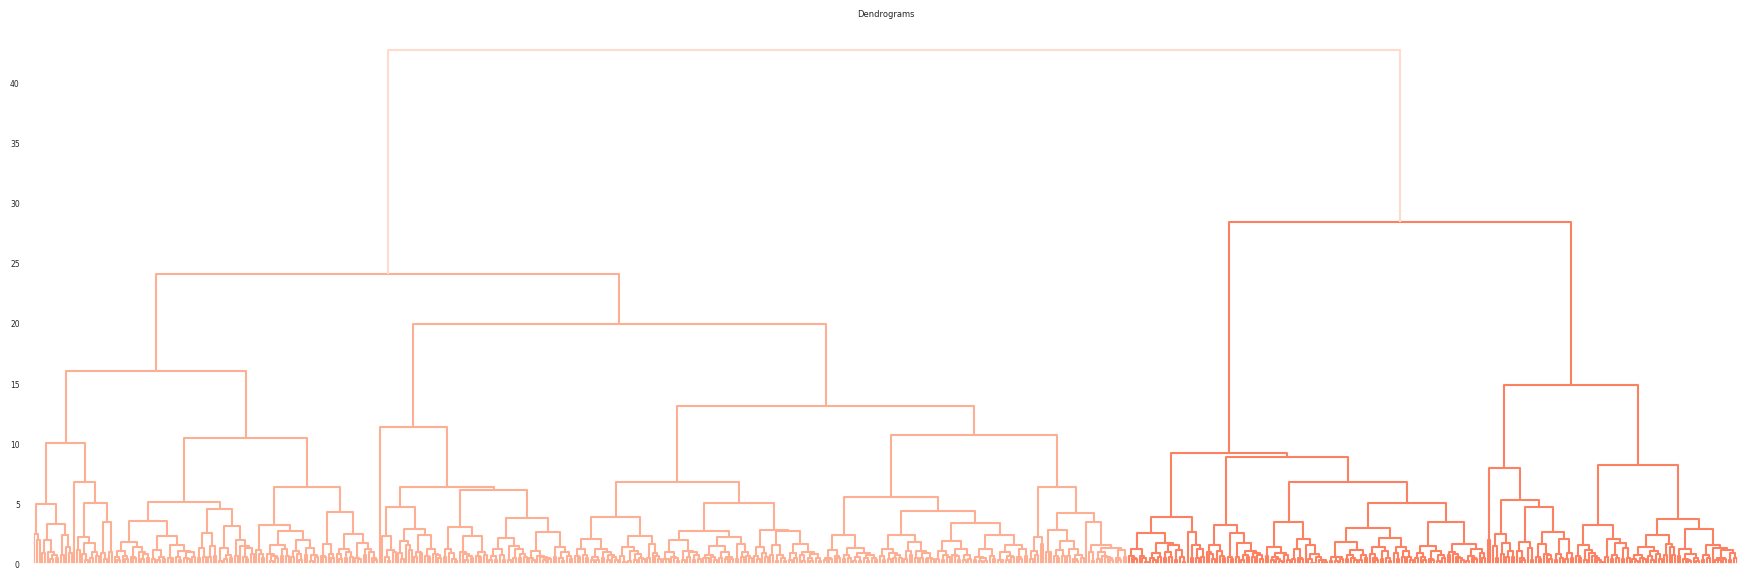

In [ ]:
import scipy.cluster.hierarchy as shc
from sklearn.preprocessing import StandardScaler

columns = ['Average VCF increase (%)', 'VCF in 2011', 'Total cultivable area (hac)', 'Proportion of rural farmers (%)', 'Proportion of agricultural labour (%)']

merged_dendro = merged_data[columns]

mpl.rcParams['font.size'] = 0


scaler = StandardScaler()
dfscaled = scaler.fit_transform(merged_dendro)

plt.figure(figsize=(22, 7))
plt.title("Dendrograms")
dend = shc.dendrogram(shc.linkage(dfscaled, method='ward'))
plt.xticks([])

sns.set_palette('Reds')

Although the dendrogram has summarised the dataset into 4 large overarching clusters, it is imperative to not excessively generalise the situation. The next step will check if n_clusters=4 is appropriate for the regionalisation by comparing it to n_clusters=8

In [ ]:
def reg_clusters(n, ax):
  w = weights.Queen.from_dataframe(merged_ksc, use_index=False)
  avcf_agg8 = cluster.AgglomerativeClustering(n_clusters=n, connectivity=w.sparse)

  #seed setup
  np.random.seed(5678)
  avcf_agg8cls = avcf_agg8.fit(merged_ksc[columns])

  merged_ksc['avcf_agg13cls'] = avcf_agg8cls.labels_

  merged_ksc.plot(column='avcf_agg13cls', categorical=True, legend=True, linewidth=0, ax=ax)

  ax.set_axis_off()
  ax.axis('equal')
  ax.set_title('Regionalisation of variables - n_clusters=' + str(n))


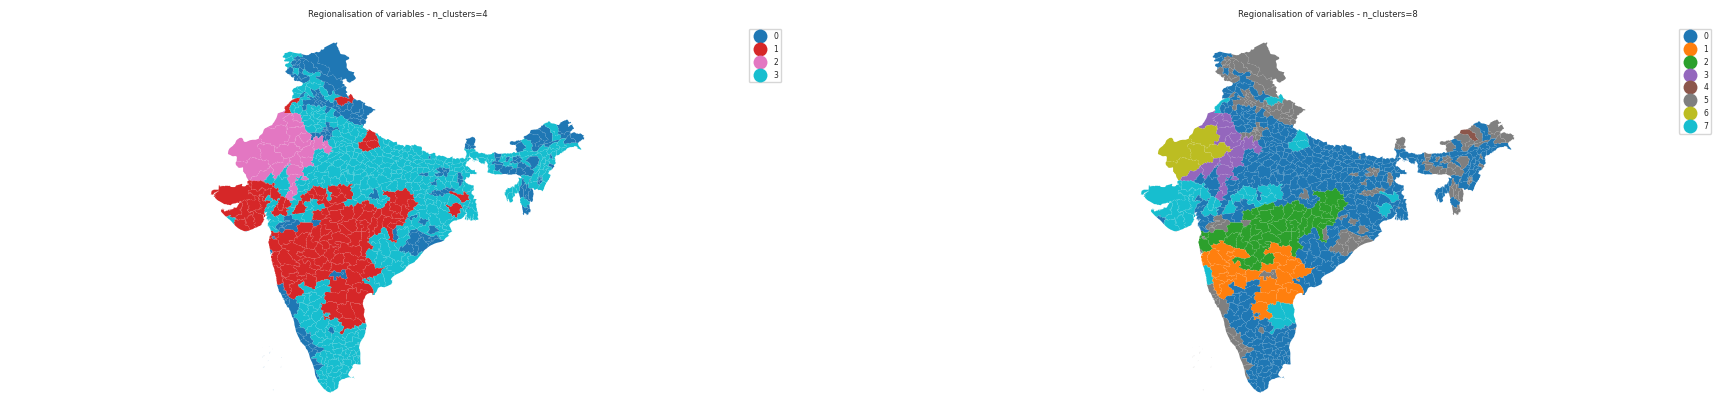

In [ ]:
import warnings
warnings.filterwarnings("ignore")

f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(22, 5))

reg_clusters(4, ax1)
reg_clusters(8, ax2)

Regions 1, 2, 5, 6 and 7 from the n_clusters=8 output are further distinguished regions from the main regions 1 and 2 from n_clusters=4. It is important to make contextual analyses, but in this case the focus should be on regions that are facing low VCF increase or even negative VCF increase - which in this case are the original regions 0 and 3 from the n_clusters=4 output. Therefore, having 4 regional clusters would suffice.

The regionalisation results display a number of regions that show differing trends in the relationships between the variables.

Regions:
-	0
-	1
-	2
-	3


As expected only a few areas do show the trend in the hypothesis (Region 0). Region 0 shows a general trend of low and even negative average VCF increase, high initial VCF, low cultivable area and high proportion of rural farmers. This region also coincides with the significant areas that resulted from the LISA analysis of the average VCF increase. These regions overlap with the areas that were indicated by the LISA analysis to be significant across all variables, showing that the trend explored in the hypothesis is not as ubiquitous as many news articles tend to portray. The hypothesis is still proven but only in some areas. Regions 0 and 4 still do cover a substantial proportion of the country’s land as seen in the plots, hence the aforementioned claims are not necessarily exaggerated.


Some districts in regions 1 and 2 actually show significant values of growth in average VCF values from 2011 to 2020 with low initial VCF values, high cultivable areas and high proportions of agricultural labour. These regions show a converse trend to that of the hypothesis and also cover a substantial area of land in India. Hence these are regions where the hypothesis does not apply, possibly due to other factors like recent environmental efforts in policy-making or different customs when it comes to agricultural techniques - not all forms of agriculture involves deforestation.

</b>

***

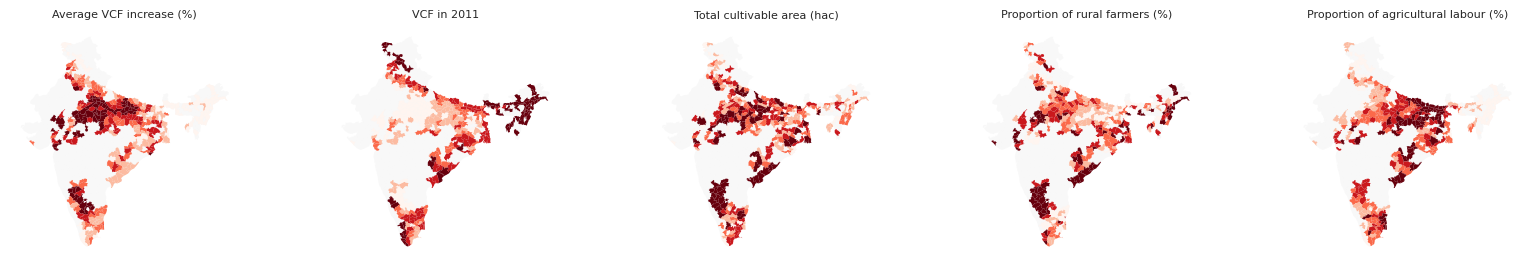

In [ ]:
merged_ksc_0 = merged_ksc[merged_ksc['avcf_agg13cls'] == 0].copy()

merged_ksc_0.reset_index(drop=True, inplace=True)


f, axs = plt.subplots(nrows=1, ncols=5, figsize=(20, 3))
axs = axs.flatten()

for i, col in enumerate(columns):
    ax = axs[i]
    merged_data.plot(ax=ax, linewidth=0, color='grey', alpha=0.05)
    merged_ksc_0.plot(column=col, ax=ax, scheme='Quantiles', linewidth=0, cmap='Reds', alpha=1)
    ax.set_axis_off()
    ax.set_title(col, fontsize=8)  # Set the font size here
    ax.tick_params(left=False, right=False, top=False, bottom=False, labelleft=False, labelright=False, labeltop=False, labelbottom=False)

plt.show()

In [ ]:
def npairplotview(n):
  merged_ksc_n = merged_ksc[merged_ksc['avcf_agg13cls'] == n].copy()

  merged_ksc_n.reset_index(drop=True, inplace=True)

  columns = ['Average VCF increase (%)', 'VCF in 2011', 'Proportion of rural farmers (%)',
            'Total cultivable area (hac)', 'Proportion of agricultural labour (%)']

  sns.set_theme()
  sns.set_style(style='whitegrid', rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
  sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'}, font_scale=0.5)

  _ = sns.pairplot(merged_ksc_n[columns], kind='reg', diag_kind='kde',
                  plot_kws={'scatter_kws': {'s': 1, 'alpha': 0.3, 'color': 'red'},
                            'line_kws': {'color': 'white', 'linewidth': 0, 'alpha': 0}},
                  diag_kws={'color': 'red', 'linewidth': 0.8}, height=2, aspect=1)

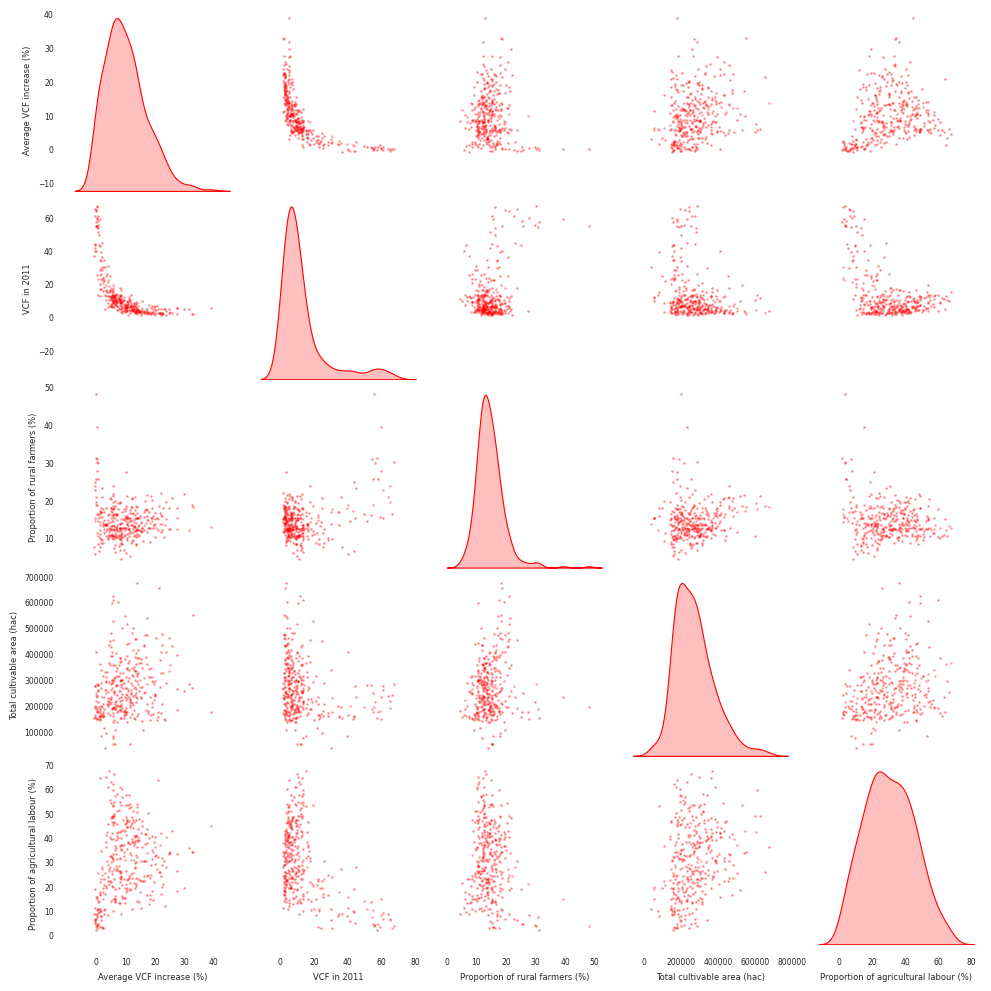

In [ ]:
npairplotview(0)

By isolating region 0 data, it can be observed that there is slightly more linearity in the correlations between some of these variables. However, it is likely that these variables have non-linear relationships with each other, considering the interconnectivity of them.

The next steps will involve using regression models to describe relationships between Average VCF increase and other variables.

#3.7 Generalised Additive Model

In [ ]:
merged_ksc_0.head()

,pc11_s_id,District ID,d_name,geometry,District name,Proportion of agricultural labour (%),Average VCF increase (%),VCF in 2011,Proportion of rural farmers (%),Total cultivable area (hac),District land size (area sqmm),avcf_agg13cls
0,01,1,Kupwara,"POLYGON ((74.46243 34.48548, 74.46090 34.48509...",Kupwara,24.778664,2.016496,28.426696,9.539445,159130.079118,257114.563426,0
1,01,5,Punch,"POLYGON ((74.30487 33.99313, 74.30529 33.99253...",Punch,19.569002,2.122981,23.615615,13.187678,156668.078084,174659.606823,0
2,01,8,Baramula,"POLYGON ((74.50265 34.40379, 74.50466 34.40242...",Baramula,20.462196,2.606969,21.666006,11.386133,113738.943076,207067.194631,0
3,01,9,Bandipore,"POLYGON ((74.66502 34.68902, 75.01727 34.62999...",Bandipore,22.021605,1.157874,17.413843,14.302622,186156.750112,253894.622048,0
4,01,16,Doda,"POLYGON ((75.50027 33.40210, 75.50061 33.40134...",Doda,8.030307,1.696178,34.106979,16.864347,200513.330209,234991.794964,0


In [ ]:
region0 = merged_ksc_0[['VCF in 2011', 'Total cultivable area (hac)', 'Proportion of rural farmers (%)', 'Proportion of agricultural labour (%)', 'Average VCF increase (%)']]
region0_x = merged_ksc_0[['VCF in 2011', 'Total cultivable area (hac)', 'Proportion of rural farmers (%)', 'Proportion of agricultural labour (%)']]
region0_y = merged_ksc_0[['Average VCF increase (%)']]

In [ ]:
region0_x.head()

,VCF in 2011,Total cultivable area (hac),Proportion of rural farmers (%),Proportion of agricultural labour (%)
0,28.426696,159130.079118,9.539445,24.778664
1,23.615615,156668.078084,13.187678,19.569002
2,21.666006,113738.943076,11.386133,20.462196
3,17.413843,186156.750112,14.302622,22.021605
4,34.106979,200513.330209,16.864347,8.030307


In [ ]:
region0_y.head()

,Average VCF increase (%)
0,2.016496
1,2.122981
2,2.606969
3,1.157874
4,1.696178


In [ ]:
n = 10

from pygam import LinearGAM, s, f

lams = np.random.rand(500, 4)
#lams = lams*100
lams = np.exp(lams)
print(lams.shape)
gam = LinearGAM(n_splines=n).gridsearch(region0_x.values, region0_y.values, lam=lams)
#gam = LinearGAM(n_splines=n).fit(region0_x.values, region0_y.values)

  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

(500, 4)


100% (500 of 500) |######################| Elapsed Time: 0:00:27 Time:  0:00:27


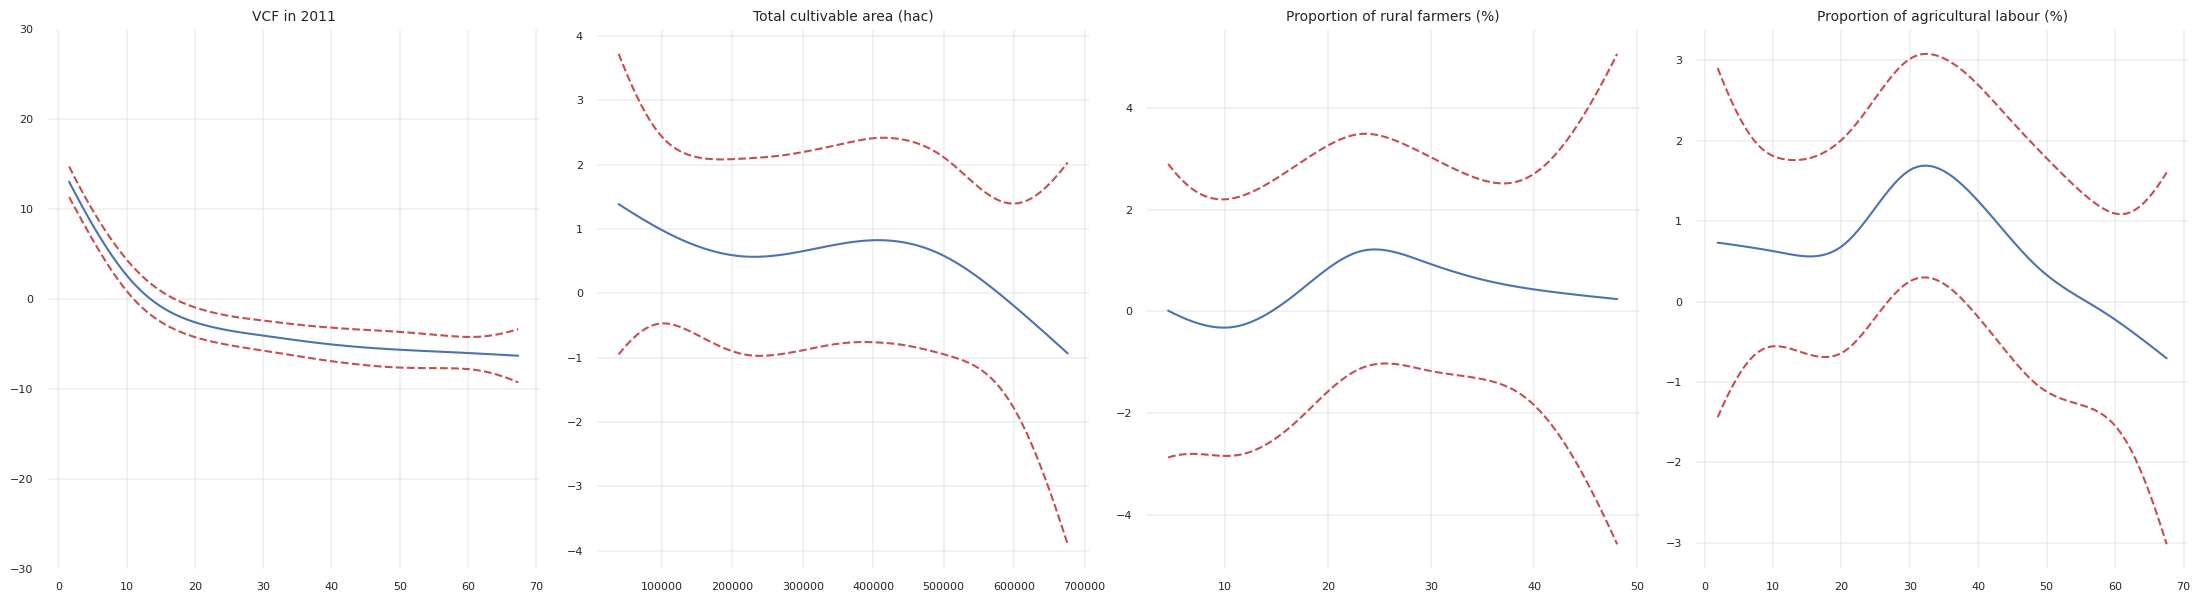

In [ ]:
titles = region0.columns
fig, axs = plt.subplots(1, 4, figsize=(22, 6))

for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')

    ax.set_title(titles[i], fontsize=10)

    if i == 0:
        ax.set_ylim(-30, 30)

    ax.set_axis_on()
    ax.tick_params(axis='both', which='major', labelsize=8, grid_color='grey', grid_alpha=0.5, grid_linewidth=0.3)


plt.tight_layout()
plt.show()

The Generalised Additive Model helped to summarise the relationships between these variables and the growth rates of forest covers in India. These regression graphs show a general downward trend where the higher in value each variable is, the lower the rate of growth of forest covers are in region 0.

However, these negative trends are not completely consistent even for region 0 where the negative correlation between variables and rate of forest cover growth is the highest. Furthermore, considering that agricultural variables were the only ones analysed in the EDA, this makes it apparent that there are more factors that impact the rate of forest growth. This could mean a number of things:
1.  For instance, political shifts between districts over the years have urged some administrations to take on more sustainable policies, aiding the growth of forest covers.
2. Agricultural practices are not homogenous throughout India. India is a very diverse country with a myriad of different customs - even pertaining to agriculture.
3. Differences in terrain and geography. Some forested areas that may be cultivable or have unused land may be less accessible, creating sudden highs in these otherwise negative trends.

#3.8 Reflections

Naturally, this analysis is not all-encompassing as there are definitely many different factors that would affect environmental problems such as forest cover growth. This hypothesis assumed that the largest players in forest cover growth in India was agricultural activities, while multi-faceted problems like these are interconnected to other socio-ecological factors. It is also possible that the districts, while belonging to the same country, are vastly different in lifestyle and agricultural practices. This analysis also used many proxies in place of other variables that could give a more direct analysis but due to the availability of the data, these were the limitations of the analysis.

The conclusions made only proved the hypothesis true to a small extent – true for only some areas. In the previous assignment, there were some conclusions drawn that mistakenly implied a causation effect. However, this analysis focuses on the spatially differentiated trends across the country. It may seem inconclusive but it paints a more accurate picture of the forest cover growth situation in India as a very varied and spatially complex issue rather than the archetypical generalisations depicted by many news articles.